# TinyTimeMixers Forecasting (Smoothed Data)
- IBM Documentation used: https://developer.ibm.com/tutorials/awb-foundation-model-time-series-forecasting/
- Github Copilot was used to aid in code generation in this notebook

In [14]:
# Get the Granite TSFM repository from GitHub
!git clone "https://github.com/ibm-granite/granite-tsfm.git"

fatal: destination path 'granite-tsfm' already exists and is not an empty directory.


In [15]:
# Core libraries
import os
import math
import tempfile
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# TSFM libraries
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback
from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)

# TSFM Toolkit libraries
from tsfm_public.toolkit.util import select_by_index
from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline
from tsfm_public.toolkit.visualization import plot_ts_forecasting

# Weights and Biases API Key needed for this notebook (can be obtained at https://wandb.ai)

In [16]:
# Load datasets
with open('../../data/processed_data_pickle_files_with_smoothing/test_data_no_batches.pkl', 'rb') as file:
    test_df = pickle.load(file)

with open('../../data/processed_data_pickle_files_with_smoothing/test_data_no_batches.pkl', 'rb') as file:
    train_df = pickle.load(file)

# Ensure data are dataframes
if not isinstance(test_df, pd.DataFrame):
    raise ValueError("Loaded data is not a pandas DataFrame.")

if not isinstance(train_df, pd.DataFrame):
    raise ValueError("Loaded data is not a pandas DataFrame.")

column_names = ['unit_number', 'sensor_2', 'sensor_3', 'sensor_4',
       'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_15', 'sensor_17', 'sensor_20',
       'sensor_21']

train_df.columns = column_names

In [17]:
print(train_df.head(20))

    unit_number  sensor_2  sensor_3  sensor_4  sensor_6  sensor_7  sensor_8  \
0           1.0  0.770741 -1.125383 -1.351873  0.426686  0.711967 -0.907467   
1           1.0 -0.022141 -0.959924 -1.415611  0.426686  0.994682 -1.007601   
2           1.0 -0.573584 -0.841134 -1.428713  0.426686  1.176803 -1.056474   
3           1.0 -1.020410 -0.746484 -1.418072  0.426686  1.315858 -1.086314   
4           1.0 -1.221147 -0.713119 -1.349510  0.426686  1.354207 -1.075036   
5           1.0 -1.224155 -0.737567 -1.230468  0.426686  1.312783 -1.037677   
6           1.0 -1.118146 -0.804648 -1.079606  0.426686  1.229457 -0.996323   
7           1.0 -0.951931 -0.895184 -0.921234  0.426686  1.129764 -0.970007   
8           1.0 -0.782482 -0.982536 -0.783121  0.426686  1.041206 -0.973061   
9           1.0 -0.657971 -1.045641 -0.681734  0.426686  0.982937 -1.007836   
10          1.0 -0.595019 -1.087176 -0.642294  0.426686  0.958644 -1.068927   
11          1.0 -0.597012 -1.126073 -0.682741  0.426

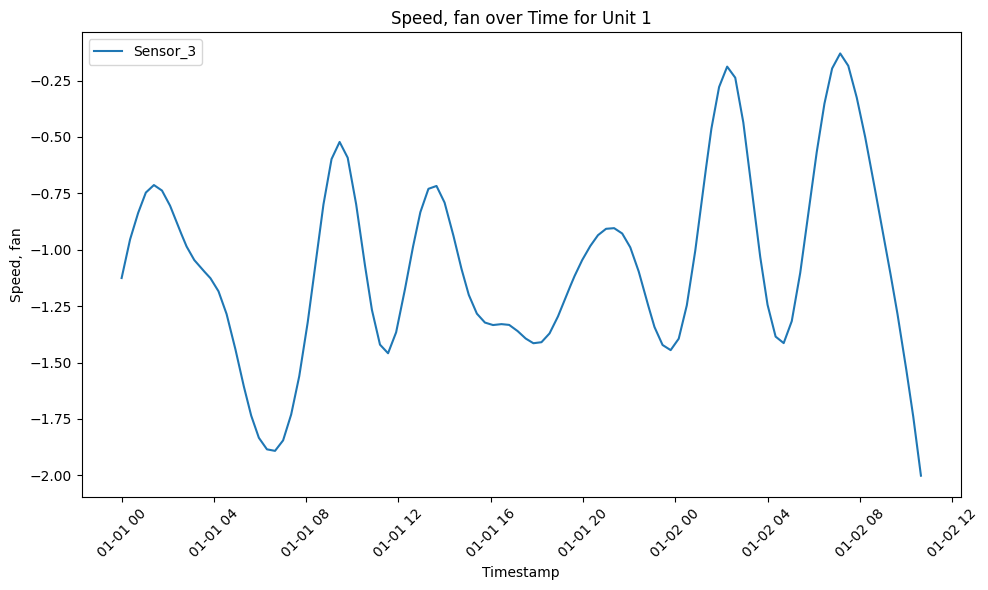

In [18]:
# Step 1 & 2: Efficiently add empty rows and timestamp for each unit_number
def expand_and_add_timestamp(df, num_empty_rows=20, start_date='2023-01-01'):
    dfs = []
    for unit_num, group in df.groupby('unit_number'):
        N = len(group)
        total_rows = N + (N - 1) * num_empty_rows
        # Create timestamps starting at midnight for each unit_number
        timestamps = pd.date_range(start=start_date, periods=total_rows, freq='min')
        # Create an empty DataFrame with timestamps
        expanded_group = pd.DataFrame({'timestamp': timestamps})
        # Calculate positions to insert the original data
        positions = np.arange(N) * (num_empty_rows + 1)
        # Assign unit_number to the expanded DataFrame
        expanded_group['unit_number'] = unit_num
        # Insert the original data into the correct positions
        expanded_group.loc[positions, group.columns] = group.values
        dfs.append(expanded_group)
    expanded_df = pd.concat(dfs, ignore_index=True)
    return expanded_df

# Step 3: Interpolate the missing values for each unit_number
def interpolate_missing_values(df):
    df = df.set_index(['unit_number', 'timestamp'])
    df = df.interpolate(method='linear')
    df = df.reset_index()
    return df


# Apply the steps to train_df
train_df = expand_and_add_timestamp(train_df)
train_df = interpolate_missing_values(train_df)

# Step 4: Plot 'Speed, fan' for unit_number = 1 over timestamp column
unit_1_data = train_df[train_df['unit_number'] == 1]
plt.figure(figsize=(10, 6))
plt.plot(unit_1_data['timestamp'], unit_1_data['sensor_3'], label='Sensor_3')
plt.xlabel('Timestamp')
plt.ylabel('Speed, fan')
plt.title('Speed, fan over Time for Unit 1')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# Refine dataset
train_df = train_df.dropna()
train_df.columns

Index(['unit_number', 'timestamp', 'sensor_2', 'sensor_3', 'sensor_4',
       'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_15', 'sensor_17', 'sensor_20',
       'sensor_21'],
      dtype='object')

# Forecasting

In [20]:
# Generate train/validation/test split configurations for each unit number in the dataset.
def generate_split_configs(input_df, context_length, unit_numbers=None):

    # If no unit numbers provided, get all unique unit numbers from the data
    if unit_numbers is None:
        unit_numbers = train_df['unit_number'].unique()

    split_configs = {}

    for unit in unit_numbers:
        # Filter data for current unit
        unit_data = input_df[input_df['unit_number'] == unit]
        #unit_data = unit_data.reset_index(drop=True)
        data_length = len(unit_data)

        # Calculate indices for train split (0 to 80%)
        train_start_index = 0
        train_end_index = round(data_length * 0.8)

        # Calculate indices for validation split (80% to 90%)
        # Shift back by context length to ensure first evaluation timestamp follows training data
        eval_start_index = round(data_length * 0.8) - context_length
        eval_end_index = round(data_length * 0.9)

        # Calculate indices for test split (90% to end)
        test_start_index = round(data_length * 0.9) - context_length
        test_end_index = data_length - 1

        # Create split configuration for current unit
        split_configs[unit] = {
            "train": [train_start_index, train_end_index],
            "valid": [eval_start_index, eval_end_index],
            "test": [test_start_index, test_end_index]
        }

    return list(split_configs.values())

In [21]:
# Function to determine actual vs predicted values
def compare_forecast(forecast, date_col, prediction_col, actual_col, delta):
  comparisons = pd.DataFrame()
  comparisons[date_col] = forecast[date_col]
  actual = []
  pred = []

  for i in range(len(forecast)):
    pred.append(forecast[prediction_col].values[i][delta - 1]) # prediction for next day
    actual.append(forecast[actual_col].values[i][delta - 1])

  comparisons['actual'] = actual
  comparisons['pred'] = pred

  return comparisons

In [22]:
print(train_df.columns)

Index(['unit_number', 'timestamp', 'sensor_2', 'sensor_3', 'sensor_4',
       'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_15', 'sensor_17', 'sensor_20',
       'sensor_21'],
      dtype='object')


In [23]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Forecasting parameters
context_length = 512 # TTM can use 512 time points into the past
forecast_length = 96 # TTM can predict 96 time points into the future
fewshot_fraction = 0.05 # 5% of the data can be used for few-shot
prediction_filter = 24 # Filter this many predicted time points

# Set column parameters
timestamp_column = "timestamp"
target_columns = ["sensor_2"]
observable_columns = train_df.columns[3:]

# Set up Column Specifiers and Preprocessor
column_specifiers = {
    "timestamp_column": timestamp_column,
    "target_columns": target_columns,
    "observable_columns": observable_columns
}

  0%|          | 0/78 [00:00<?, ?it/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kanungle (kanungle-kx-systems). Use `wandb login --relogin` to force relogin


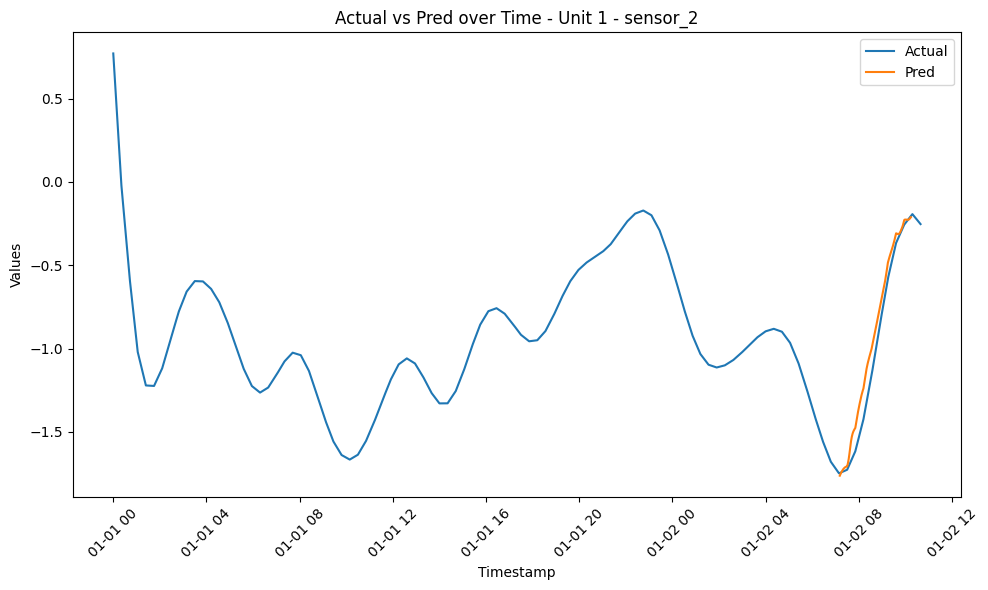

RMSE for Unit 1 - sensor_2: 0.12223608305458258


  0%|          | 0/78 [00:00<?, ?it/s]

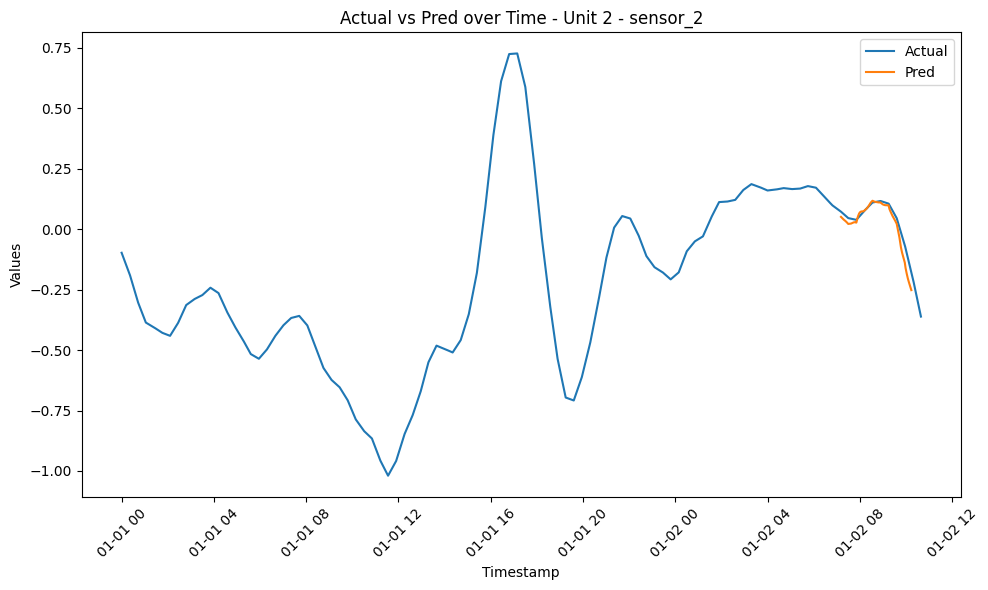

RMSE for Unit 2 - sensor_2: 0.05474997777755445


  0%|          | 0/85 [00:00<?, ?it/s]

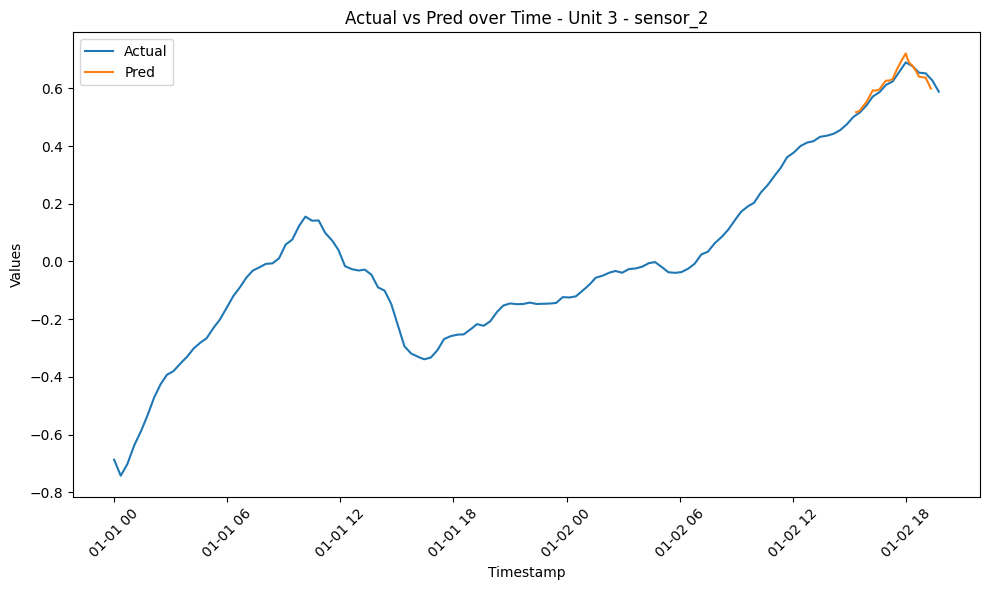

RMSE for Unit 3 - sensor_2: 0.01831261505253863


  0%|          | 0/80 [00:00<?, ?it/s]

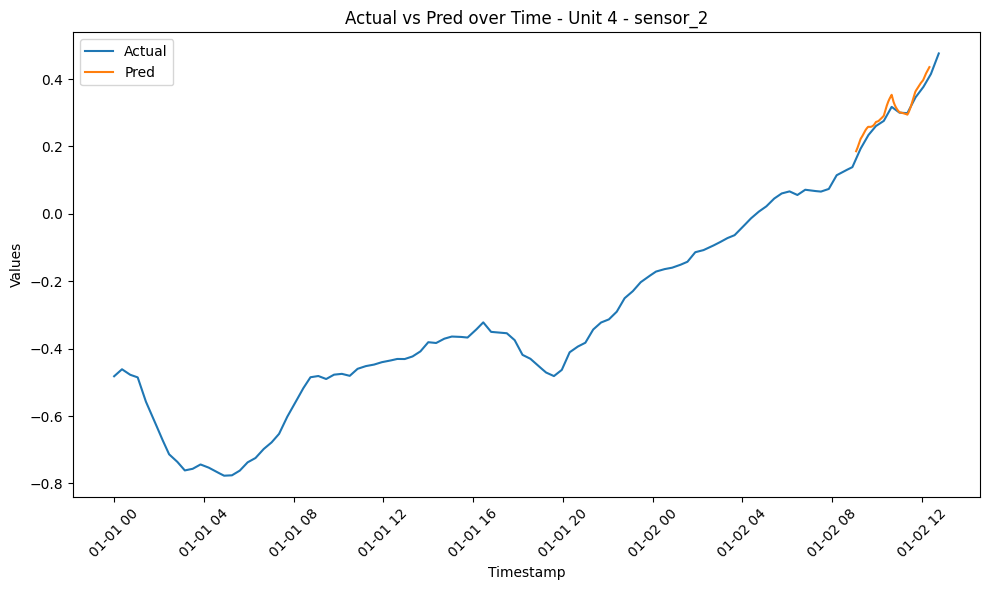

RMSE for Unit 4 - sensor_2: 0.02684734687935881


  0%|          | 0/78 [00:00<?, ?it/s]

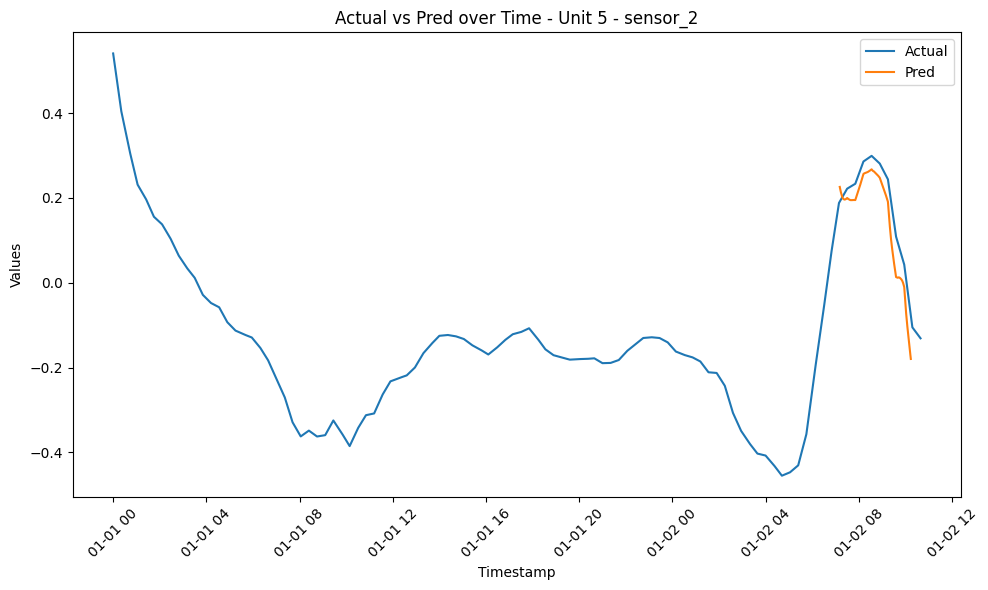

RMSE for Unit 5 - sensor_2: 0.05261307012271344


  0%|          | 0/80 [00:00<?, ?it/s]

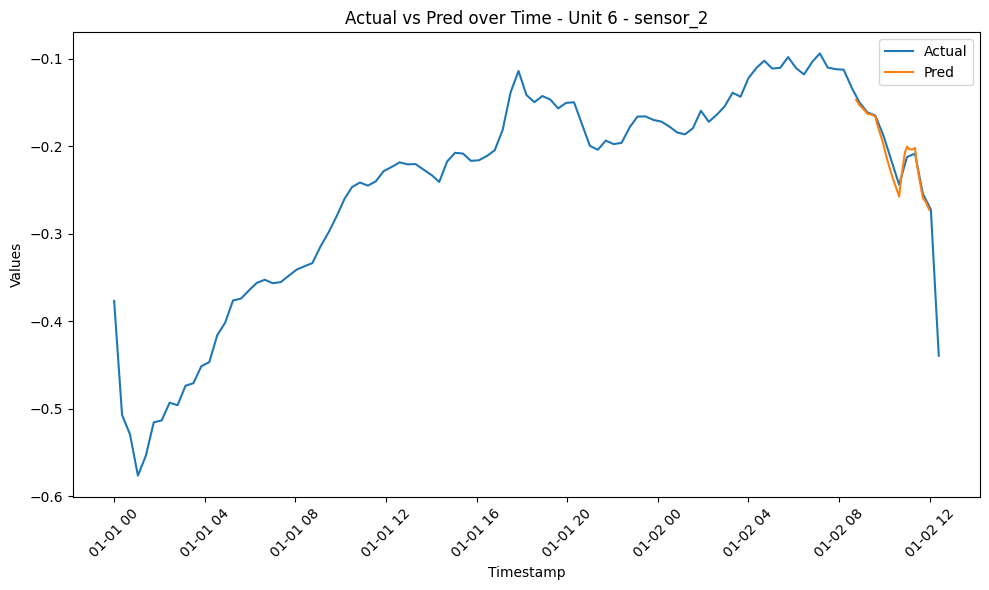

RMSE for Unit 6 - sensor_2: 0.039506402774243374


  0%|          | 0/94 [00:00<?, ?it/s]

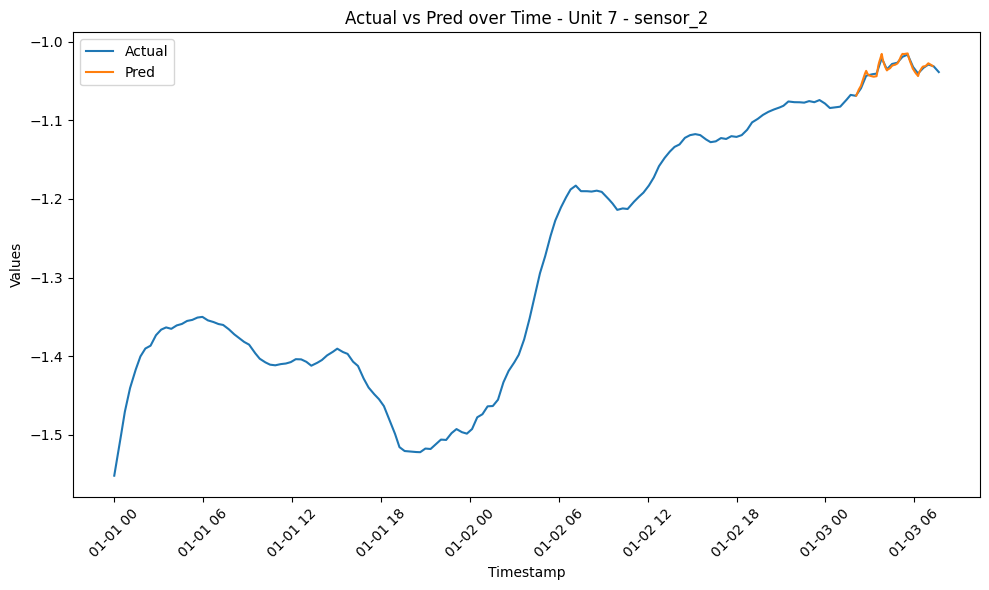

RMSE for Unit 7 - sensor_2: 0.009073878815231355


  0%|          | 0/96 [00:00<?, ?it/s]

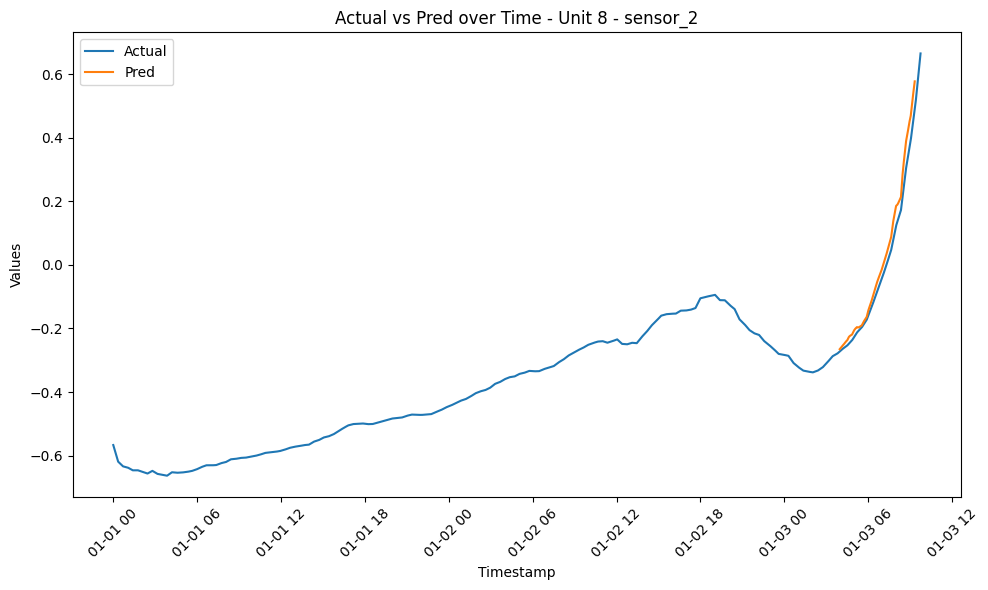

RMSE for Unit 8 - sensor_2: 0.034623066924294295


  0%|          | 0/78 [00:00<?, ?it/s]

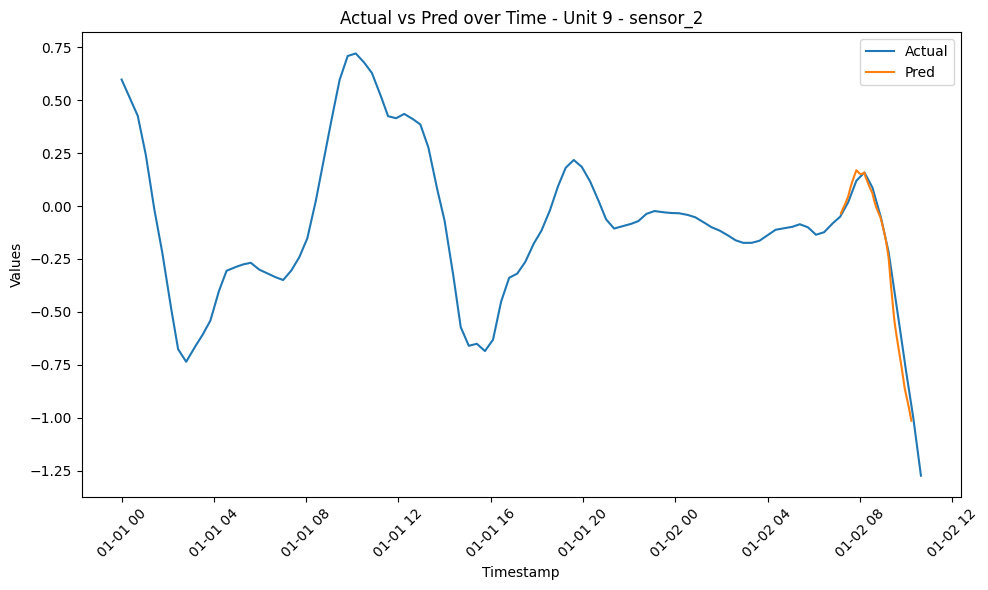

RMSE for Unit 9 - sensor_2: 0.15303427926218835


  0%|          | 0/103 [00:00<?, ?it/s]

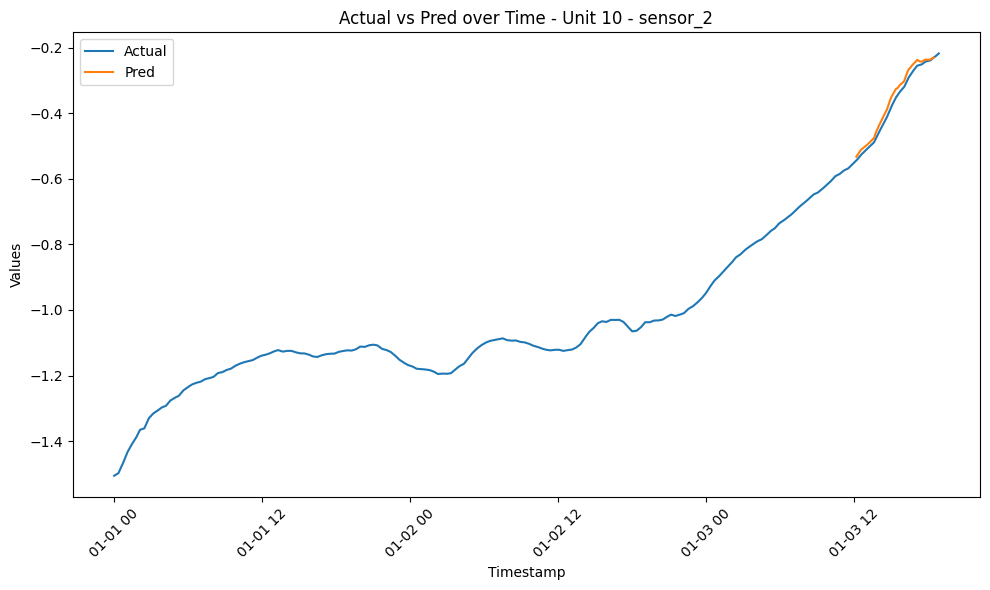

RMSE for Unit 10 - sensor_2: 0.006829099459630642


  0%|          | 0/78 [00:00<?, ?it/s]

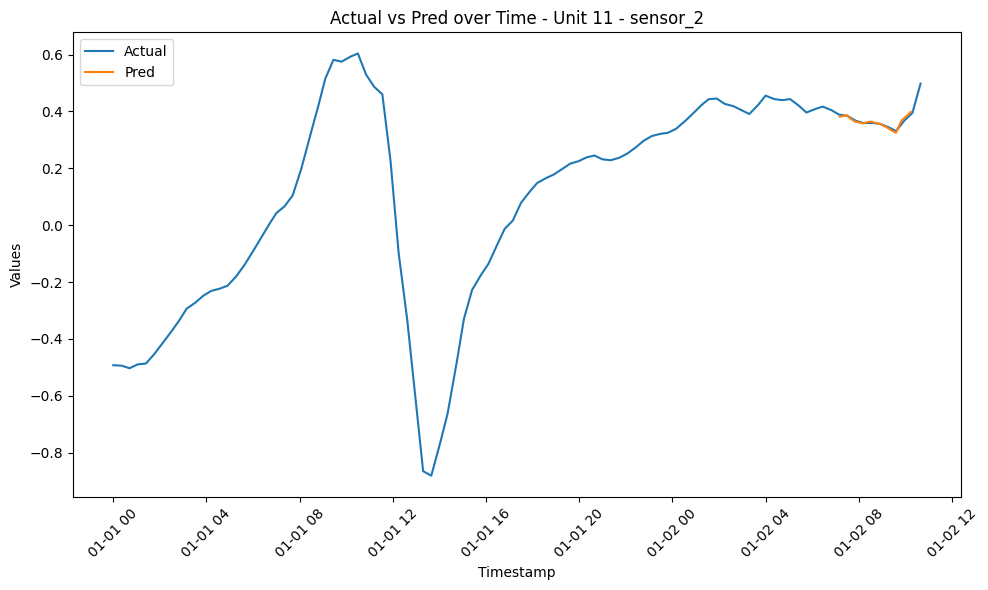

RMSE for Unit 11 - sensor_2: 0.026220289312440484


  0%|          | 0/109 [00:00<?, ?it/s]

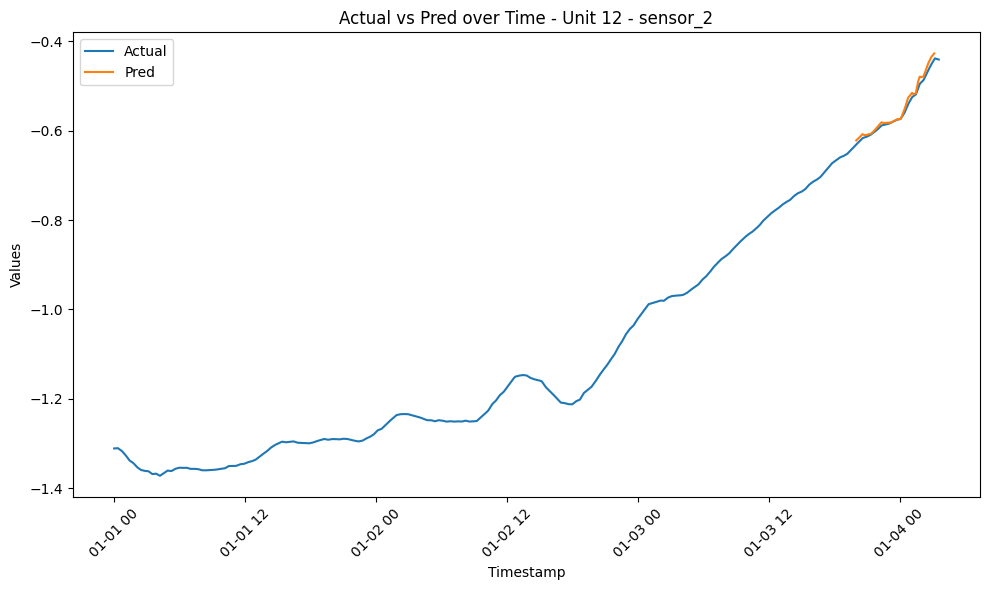

RMSE for Unit 12 - sensor_2: 0.007180035187625836


  0%|          | 0/103 [00:00<?, ?it/s]

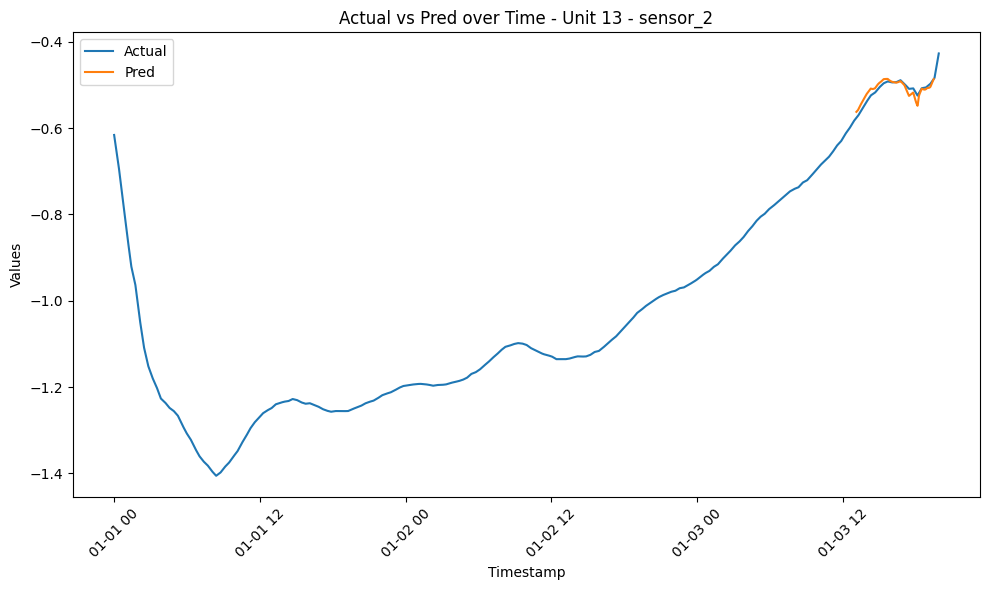

RMSE for Unit 13 - sensor_2: 0.01380384230949783


  0%|          | 0/78 [00:00<?, ?it/s]

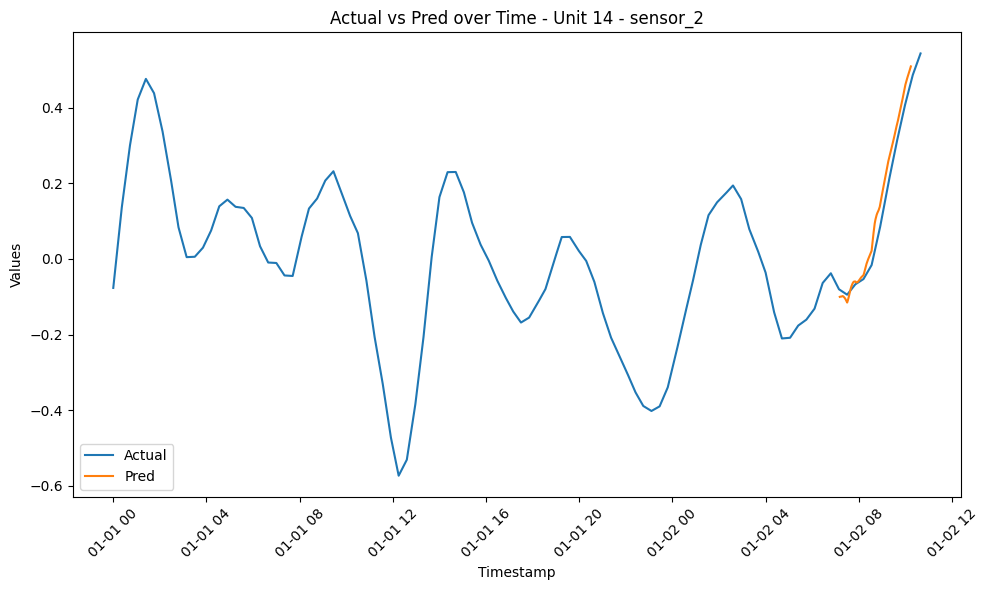

RMSE for Unit 14 - sensor_2: 0.049590336250113304


  0%|          | 0/78 [00:00<?, ?it/s]

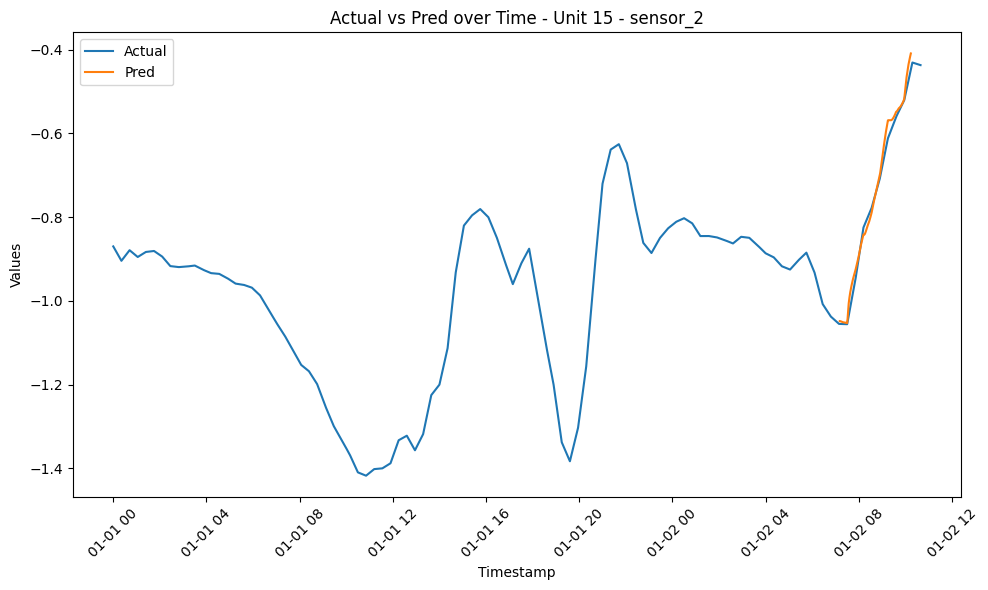

RMSE for Unit 15 - sensor_2: 0.07711158002025167


  0%|          | 0/82 [00:00<?, ?it/s]

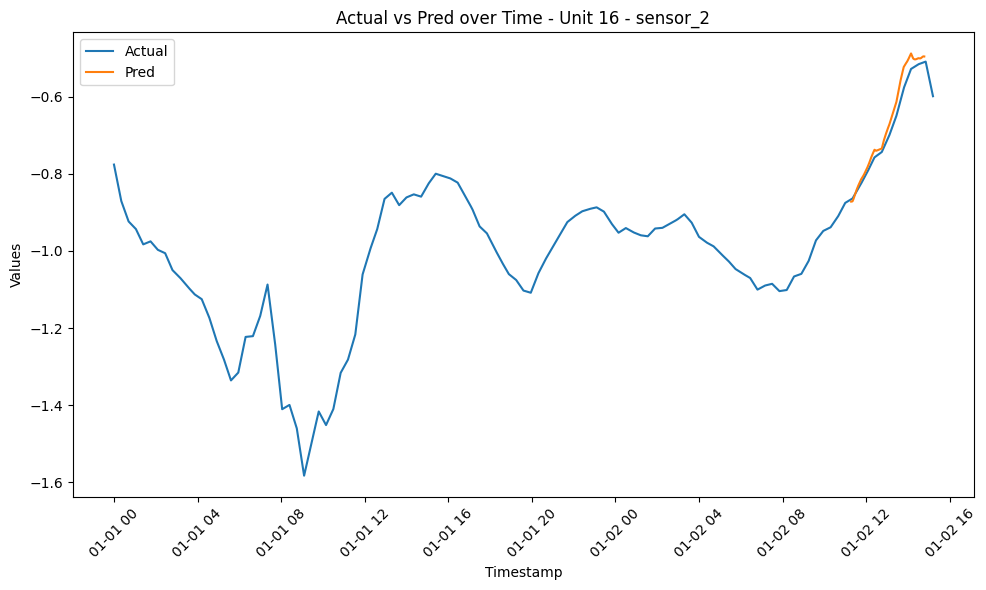

RMSE for Unit 16 - sensor_2: 0.0328774261984338


  0%|          | 0/96 [00:00<?, ?it/s]

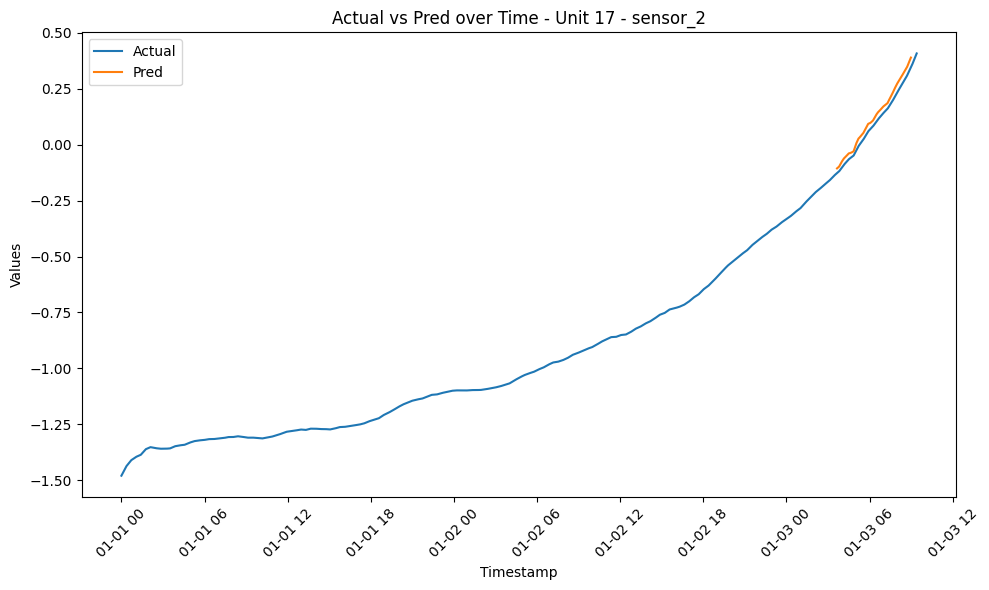

RMSE for Unit 17 - sensor_2: 0.008853915200846602


  0%|          | 0/87 [00:00<?, ?it/s]

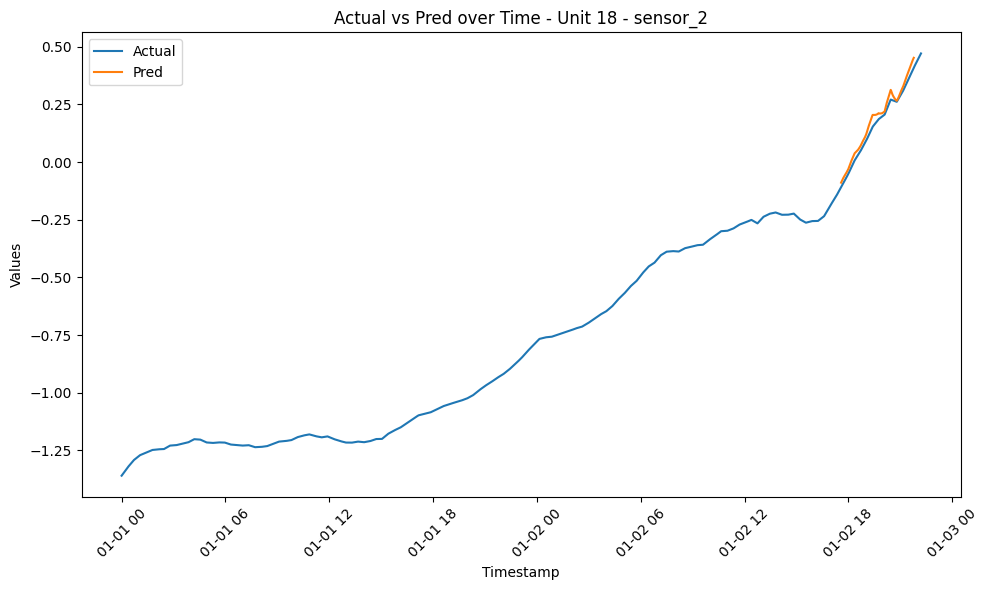

RMSE for Unit 18 - sensor_2: 0.03193118202450602


  0%|          | 0/88 [00:00<?, ?it/s]

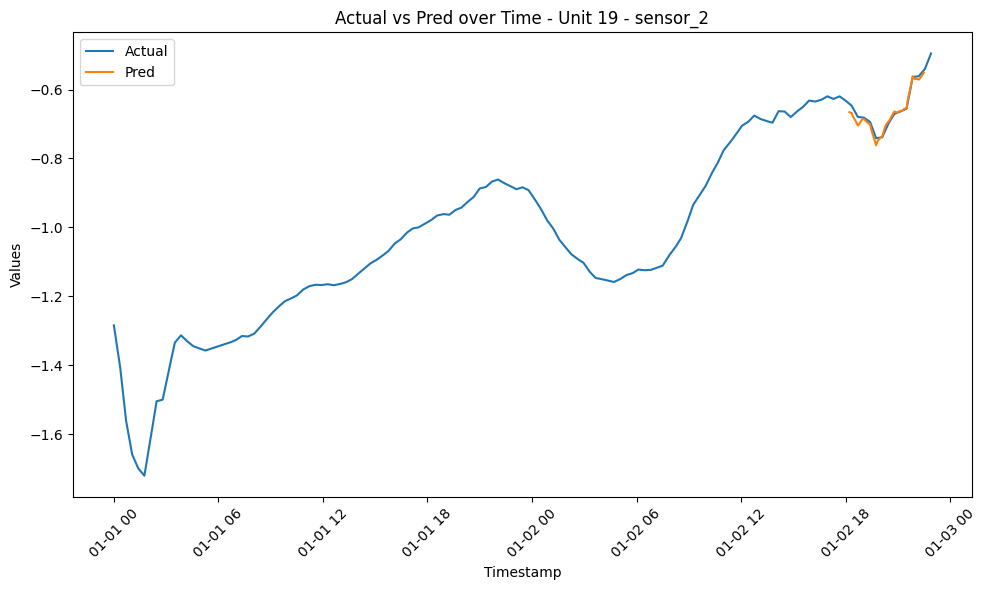

RMSE for Unit 19 - sensor_2: 0.03234622245117209


  0%|          | 0/100 [00:00<?, ?it/s]

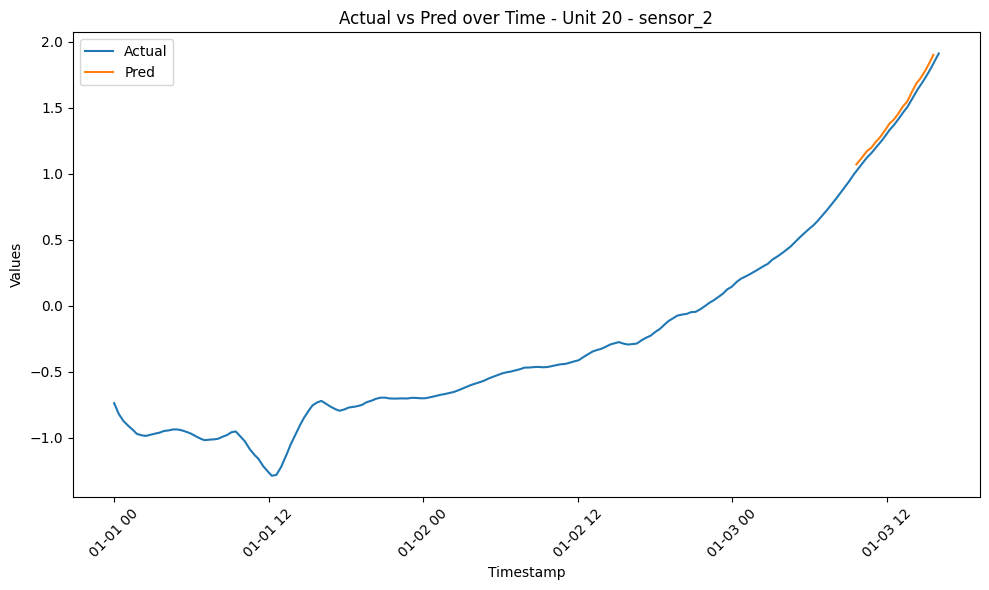

RMSE for Unit 20 - sensor_2: 0.009160165789702895


  0%|          | 0/91 [00:00<?, ?it/s]

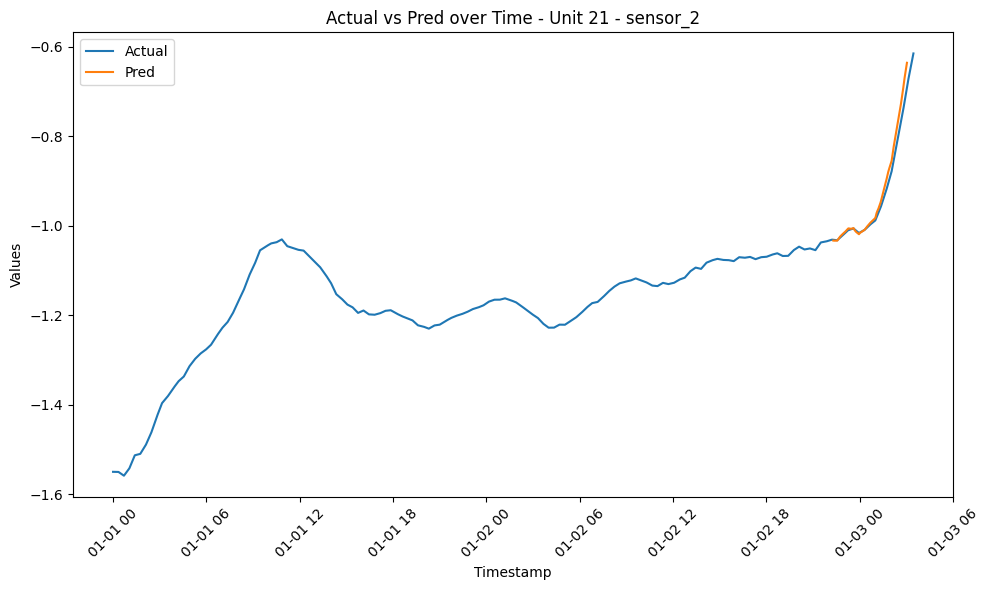

RMSE for Unit 21 - sensor_2: 0.024560455783865693


  0%|          | 0/78 [00:00<?, ?it/s]

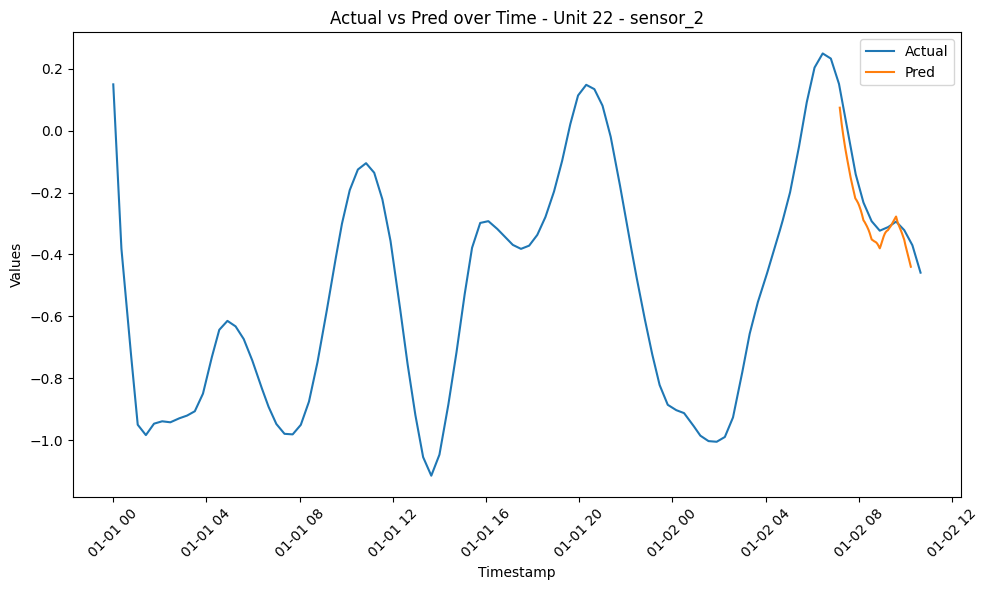

RMSE for Unit 22 - sensor_2: 0.040599242776031455


  0%|          | 0/86 [00:00<?, ?it/s]

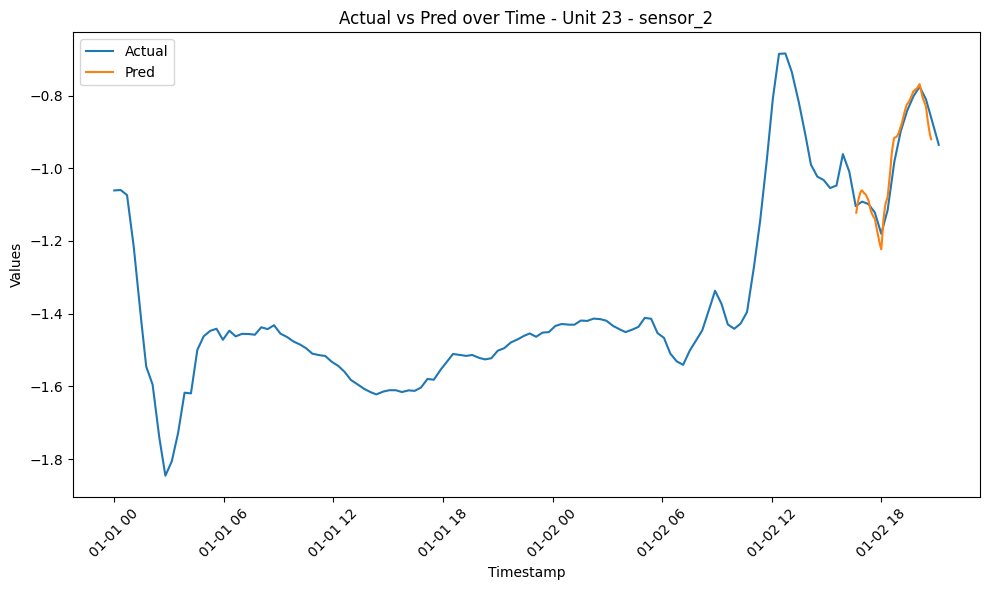

RMSE for Unit 23 - sensor_2: 0.049961888853199785


  0%|          | 0/101 [00:00<?, ?it/s]

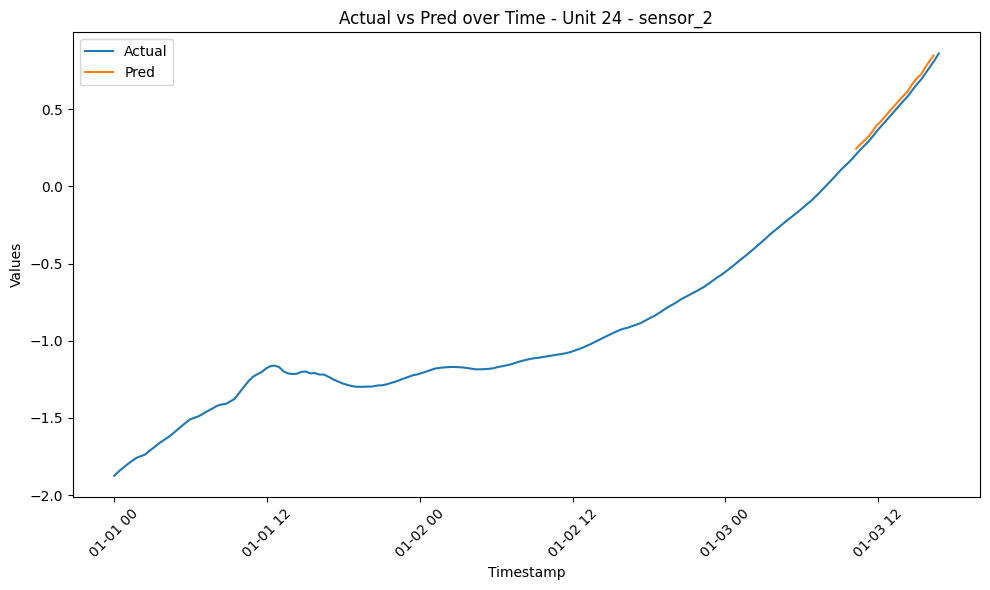

RMSE for Unit 24 - sensor_2: 0.005527555674151924


  0%|          | 0/78 [00:00<?, ?it/s]

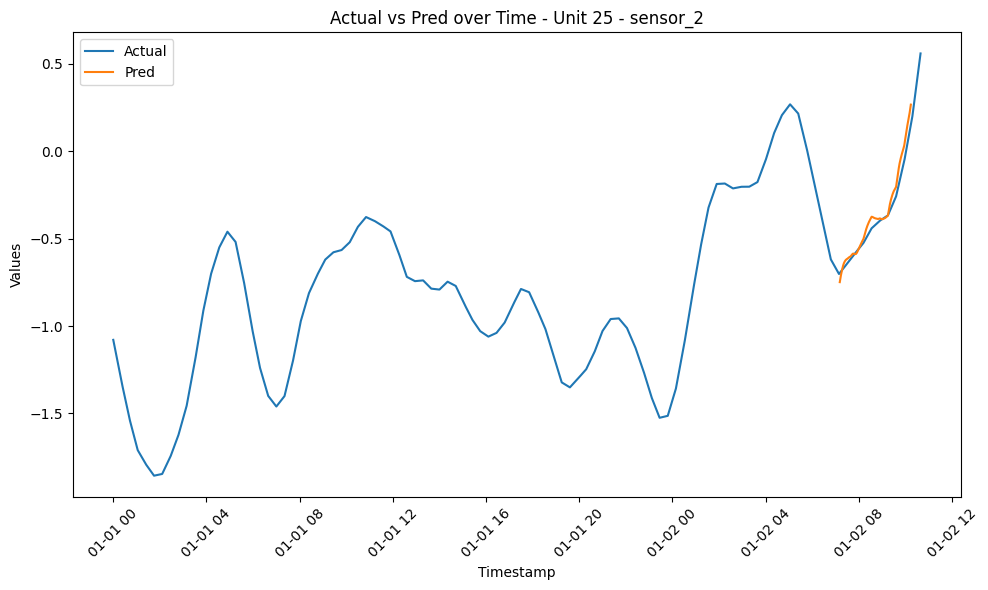

RMSE for Unit 25 - sensor_2: 0.11908390304155868


  0%|          | 0/78 [00:00<?, ?it/s]

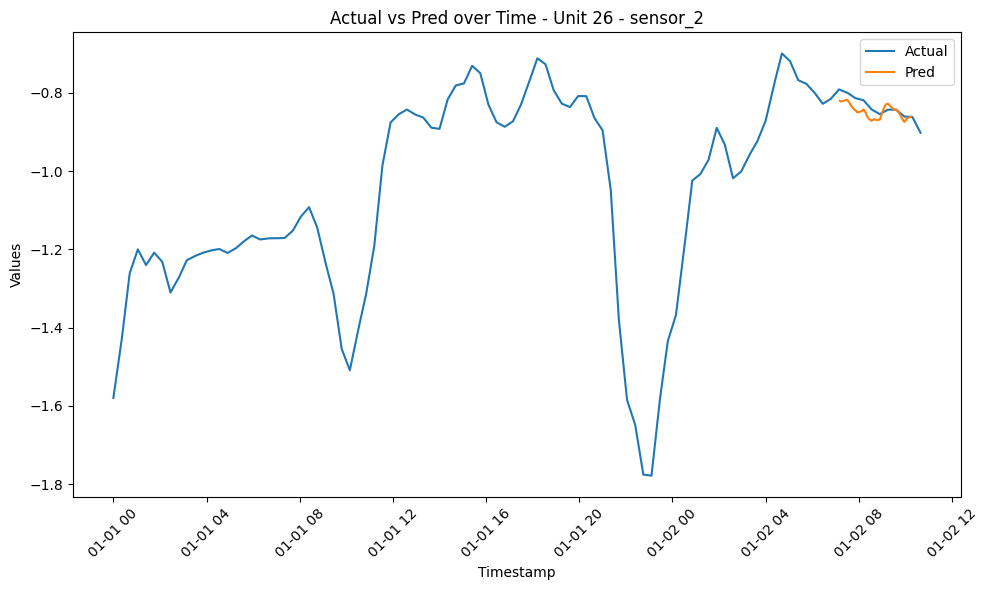

RMSE for Unit 26 - sensor_2: 0.01600252953357713


  0%|          | 0/89 [00:00<?, ?it/s]

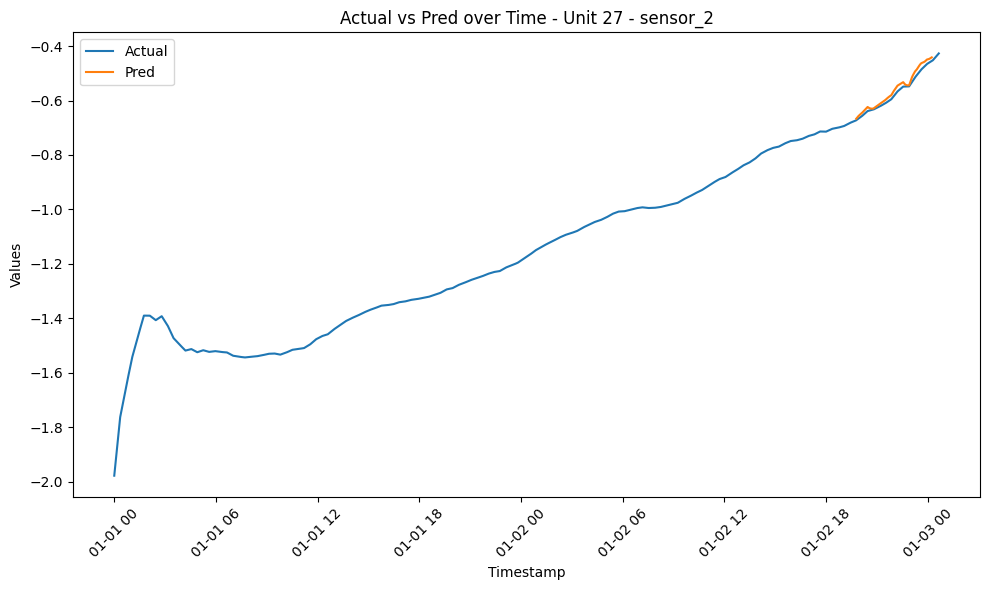

RMSE for Unit 27 - sensor_2: 0.010472849805951768


  0%|          | 0/94 [00:00<?, ?it/s]

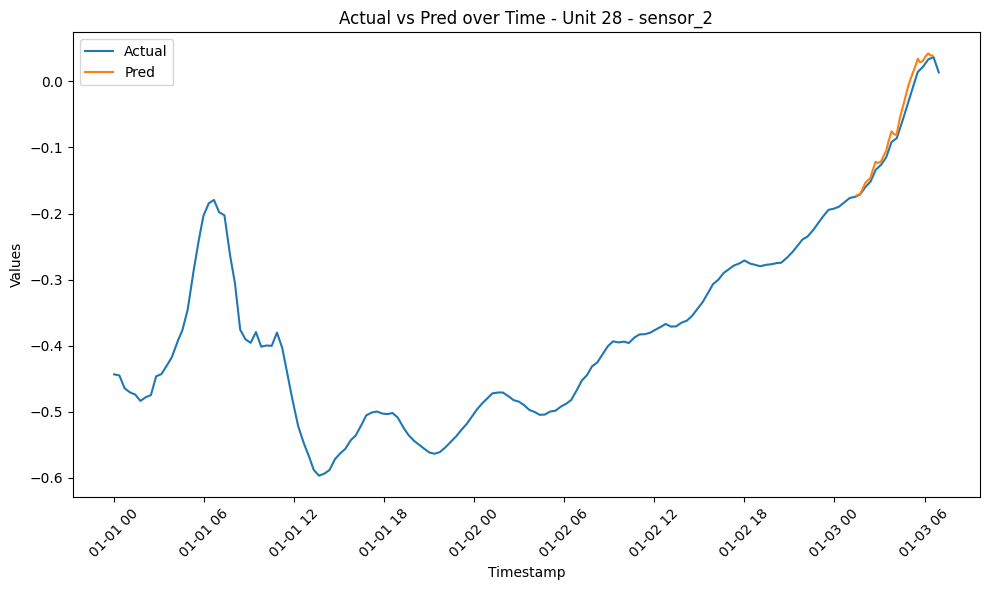

RMSE for Unit 28 - sensor_2: 0.009241991321808555


  0%|          | 0/97 [00:00<?, ?it/s]

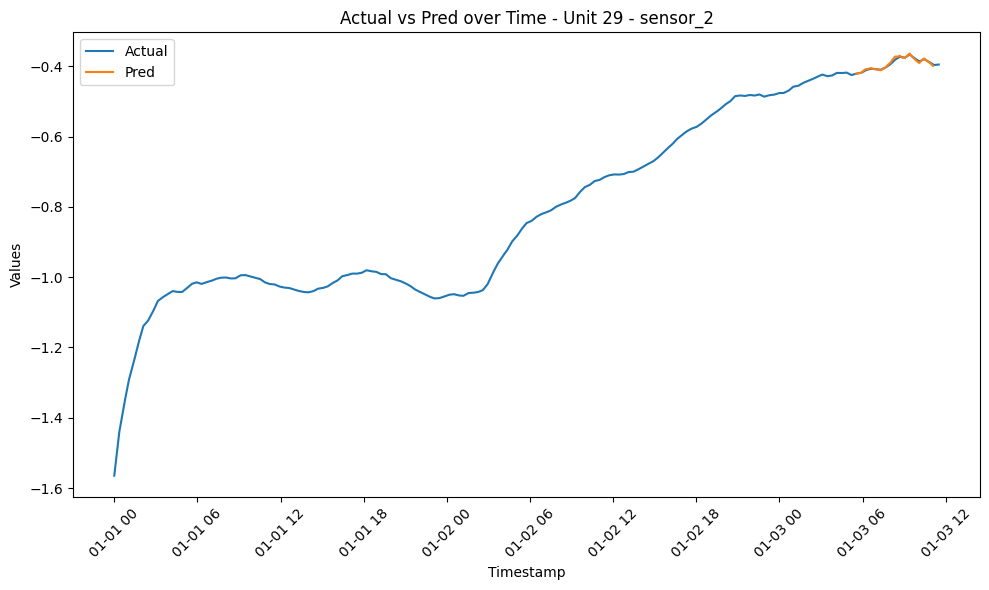

RMSE for Unit 29 - sensor_2: 0.0068206294394957435


  0%|          | 0/90 [00:00<?, ?it/s]

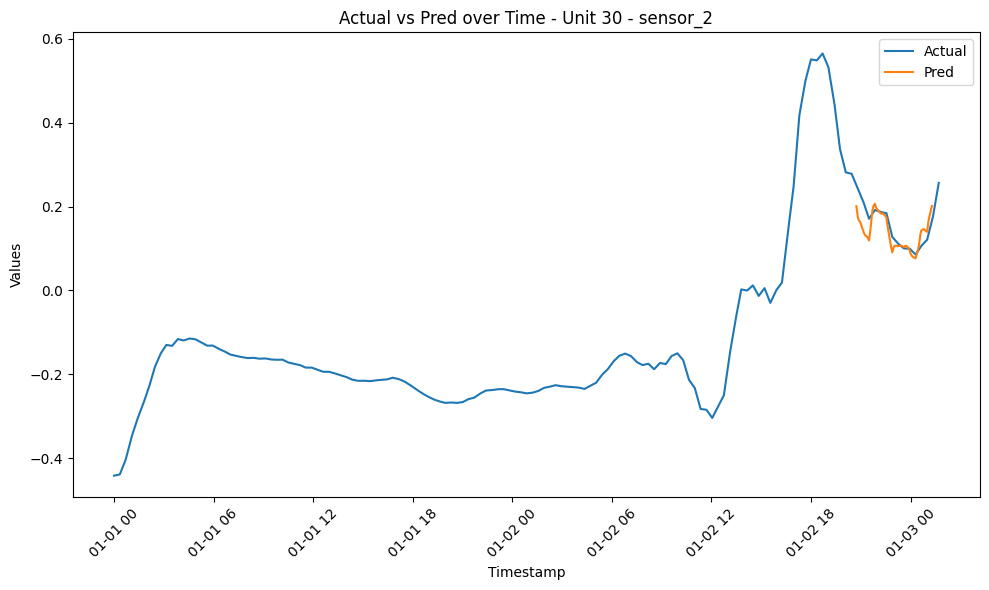

RMSE for Unit 30 - sensor_2: 0.027530171460023213


  0%|          | 0/104 [00:00<?, ?it/s]

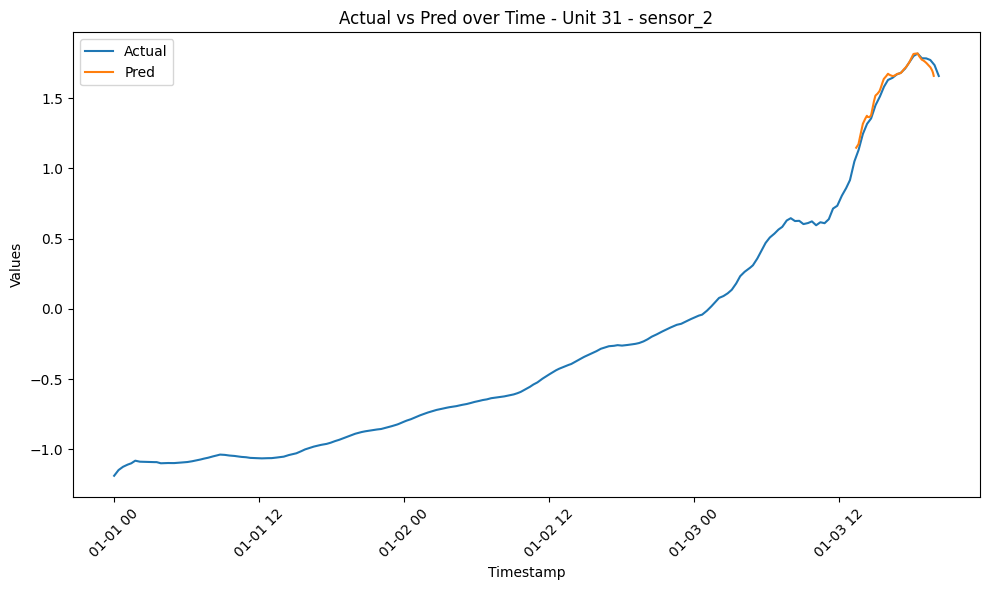

RMSE for Unit 31 - sensor_2: 0.031053668770884883


  0%|          | 0/90 [00:00<?, ?it/s]

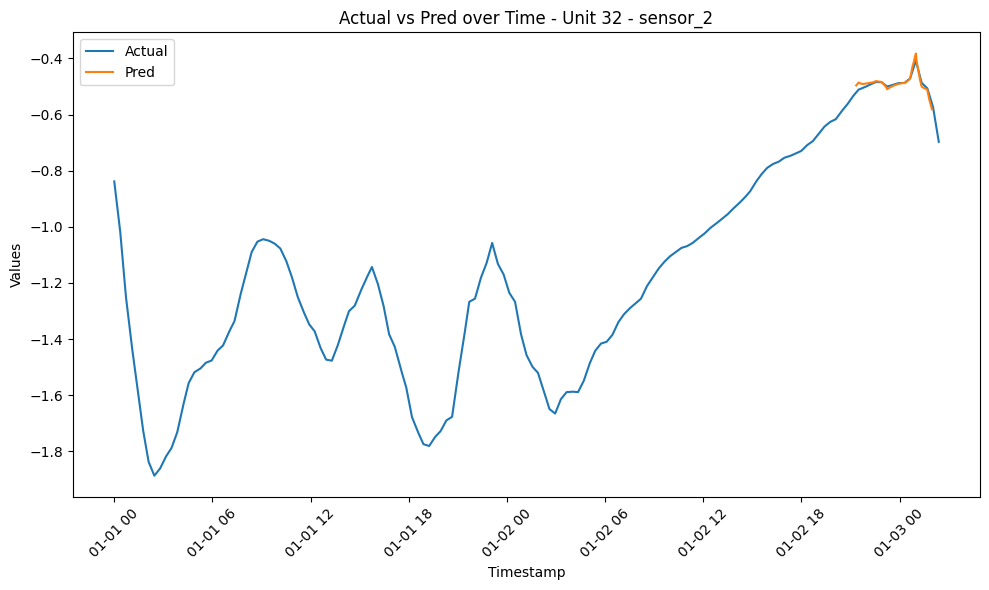

RMSE for Unit 32 - sensor_2: 0.0381859813292373


  0%|          | 0/78 [00:00<?, ?it/s]

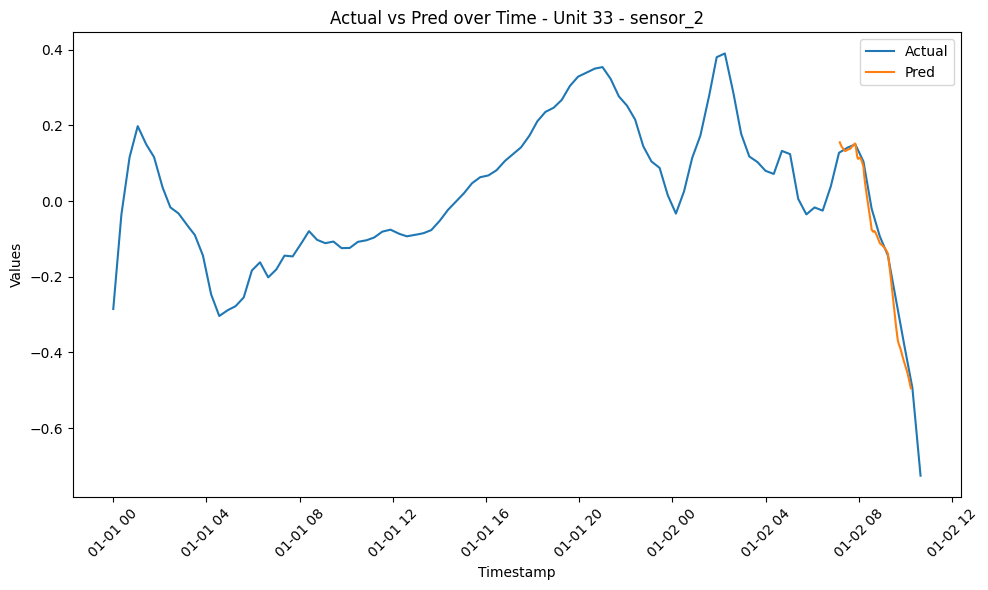

RMSE for Unit 33 - sensor_2: 0.0872353484435265


  0%|          | 0/105 [00:00<?, ?it/s]

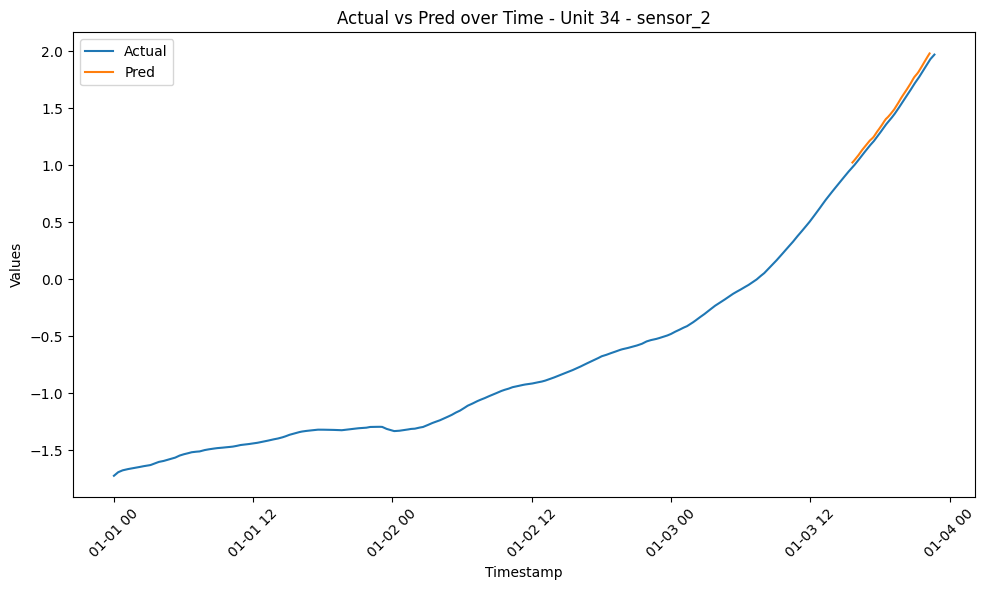

RMSE for Unit 34 - sensor_2: 0.008829019028603733


  0%|          | 0/104 [00:00<?, ?it/s]

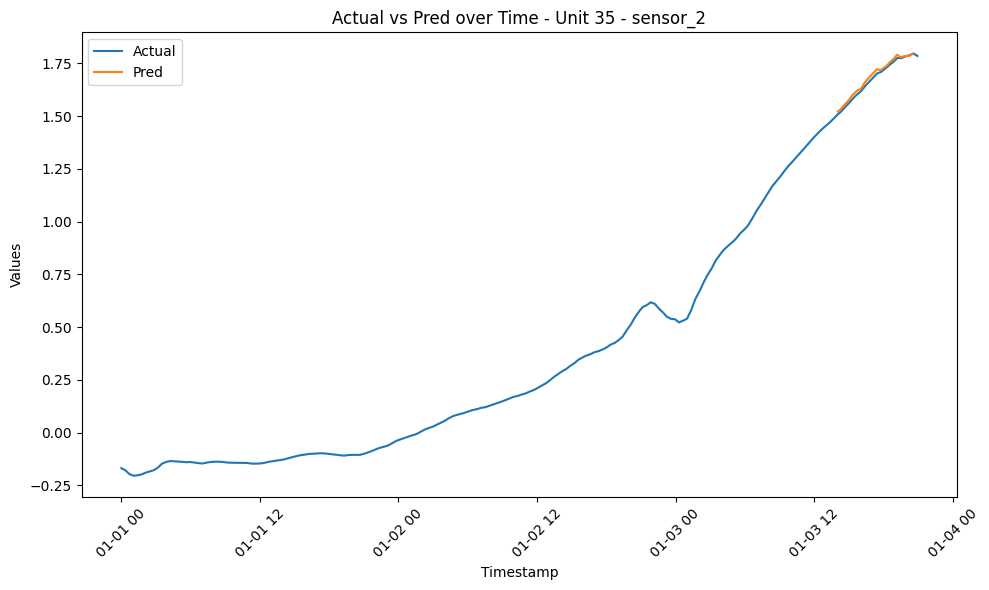

RMSE for Unit 35 - sensor_2: 0.007582708588136568


  0%|          | 0/85 [00:00<?, ?it/s]

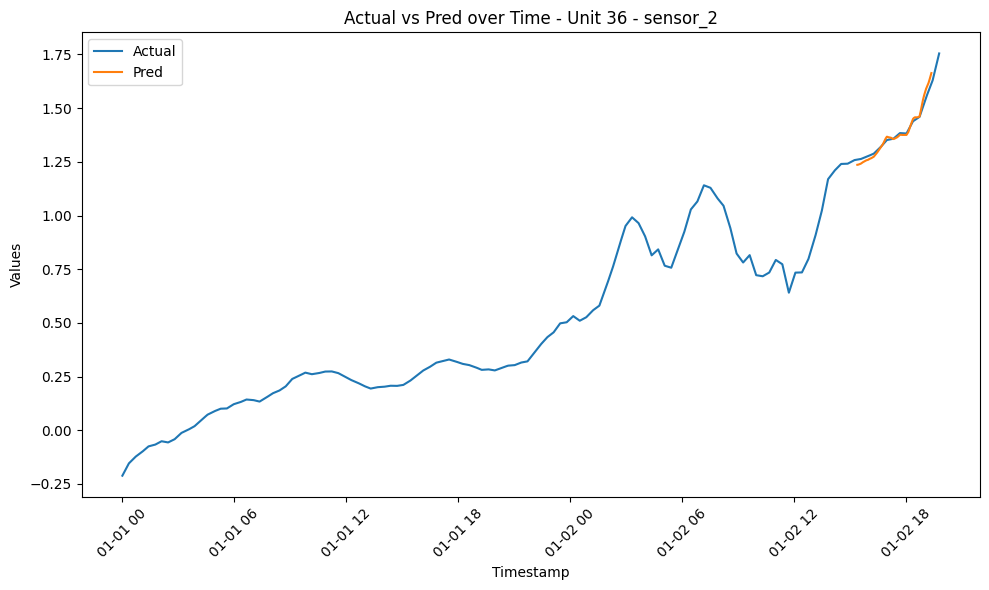

RMSE for Unit 36 - sensor_2: 0.04693562060813096


  0%|          | 0/84 [00:00<?, ?it/s]

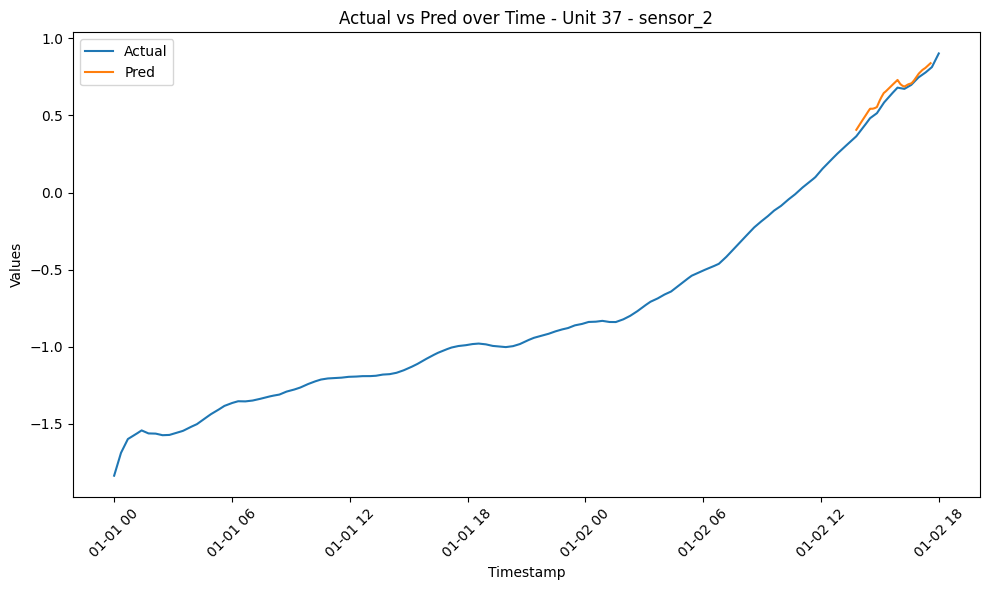

RMSE for Unit 37 - sensor_2: 0.02454617457992993


  0%|          | 0/85 [00:00<?, ?it/s]

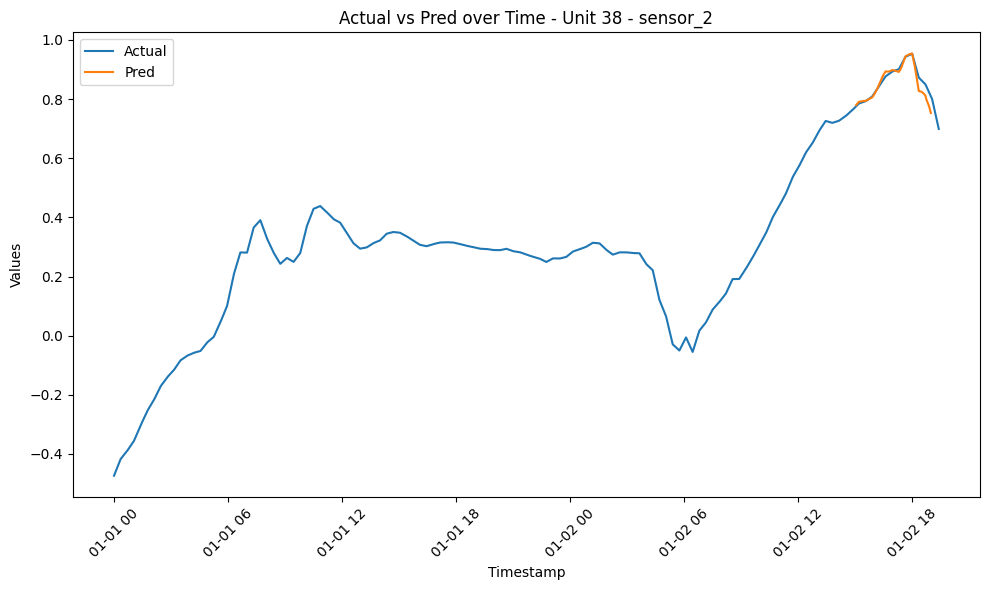

RMSE for Unit 38 - sensor_2: 0.032885477999300916


  0%|          | 0/78 [00:00<?, ?it/s]

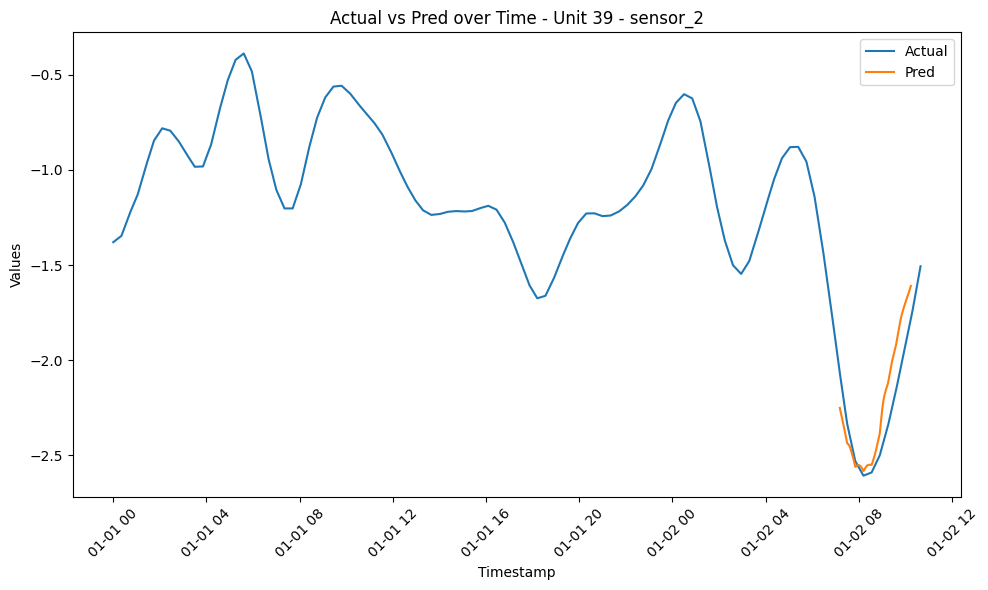

RMSE for Unit 39 - sensor_2: 0.0642354292187617


  0%|          | 0/87 [00:00<?, ?it/s]

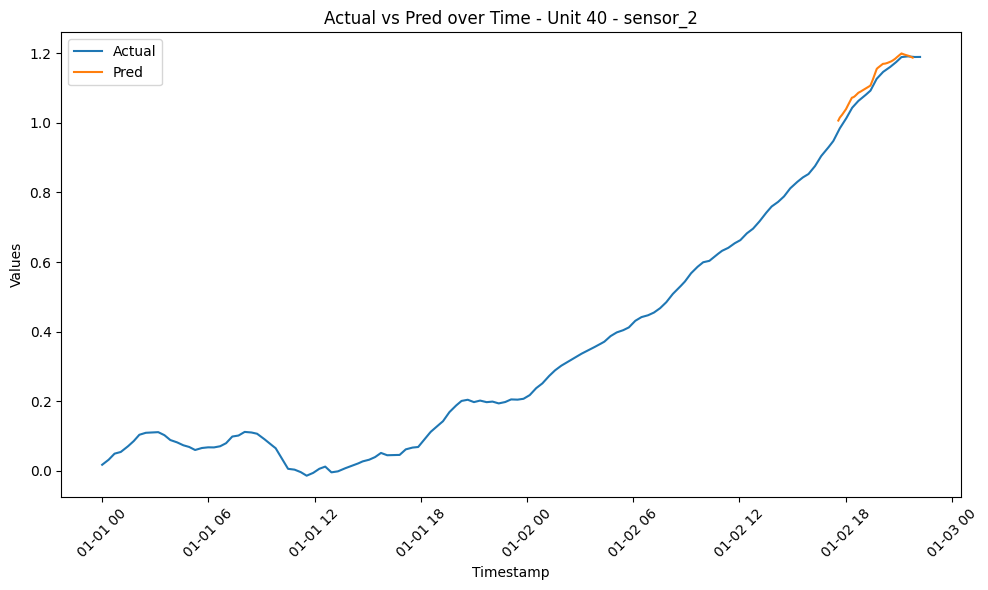

RMSE for Unit 40 - sensor_2: 0.007299263443016307


  0%|          | 0/84 [00:00<?, ?it/s]

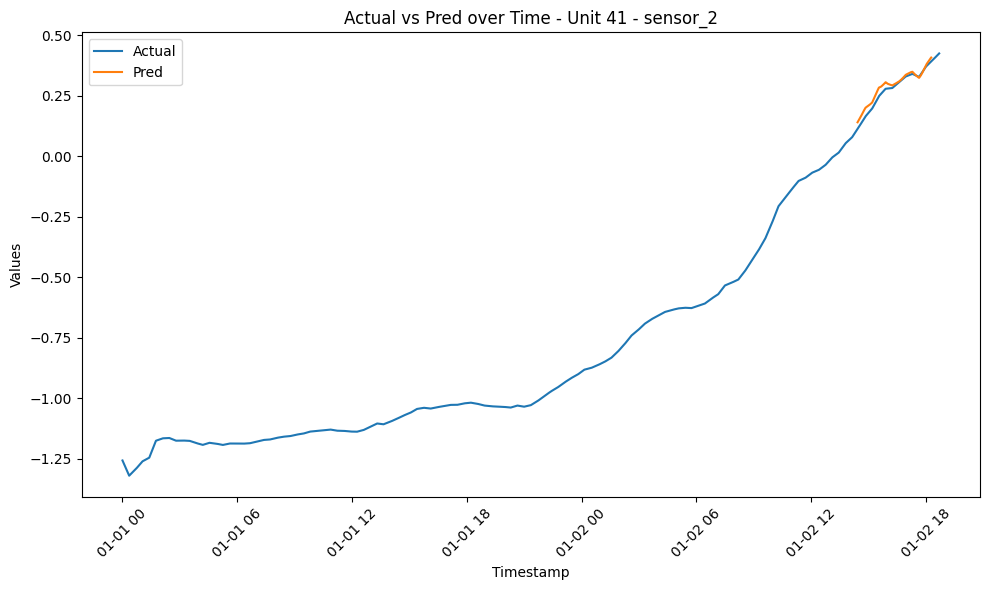

RMSE for Unit 41 - sensor_2: 0.02070558522317497


  0%|          | 0/93 [00:00<?, ?it/s]

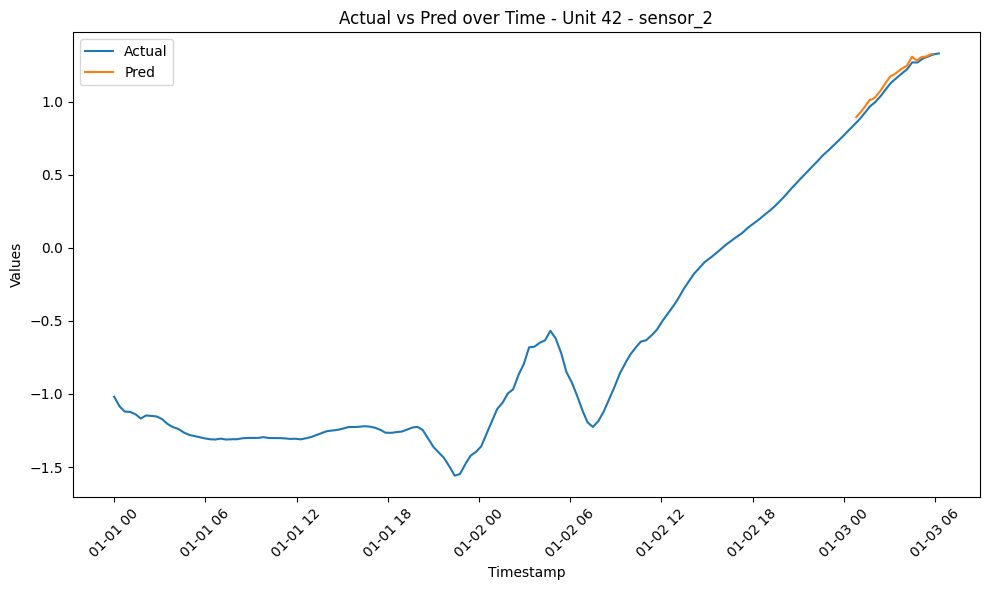

RMSE for Unit 42 - sensor_2: 0.011383109762330758


  0%|          | 0/97 [00:00<?, ?it/s]

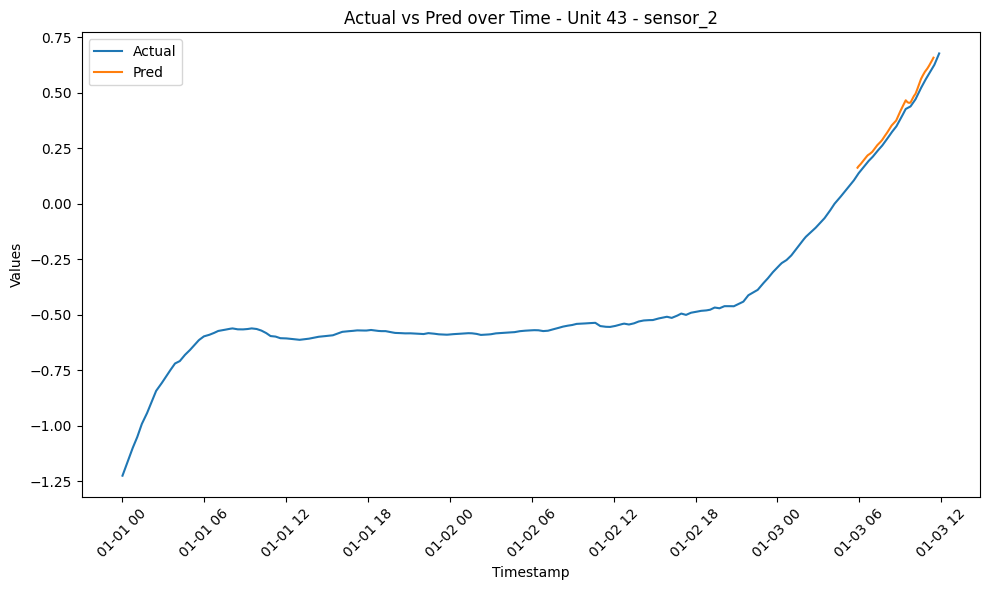

RMSE for Unit 43 - sensor_2: 0.010244997199544997


  0%|          | 0/78 [00:00<?, ?it/s]

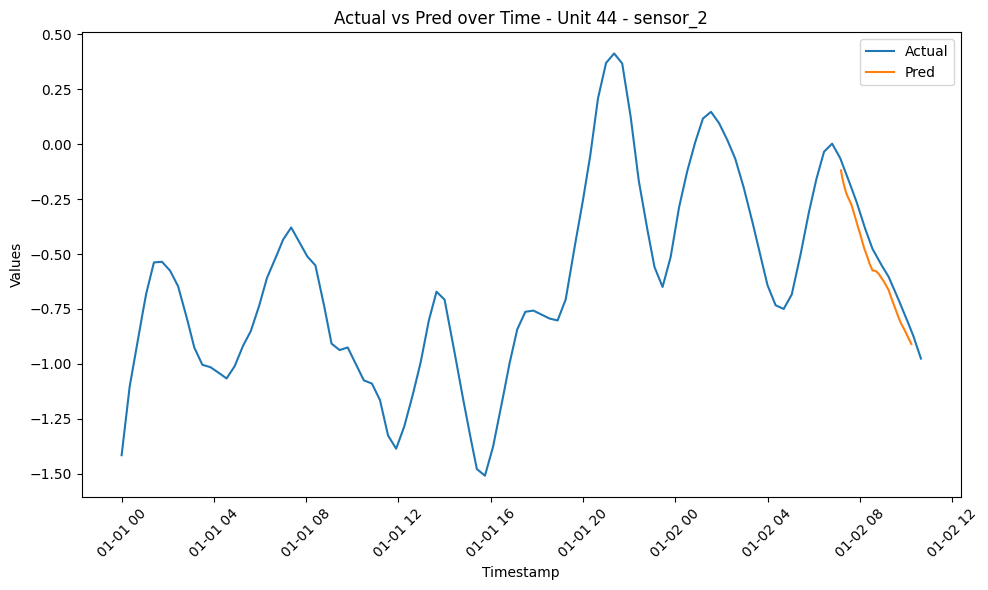

RMSE for Unit 44 - sensor_2: 0.030920596171177917


  0%|          | 0/92 [00:00<?, ?it/s]

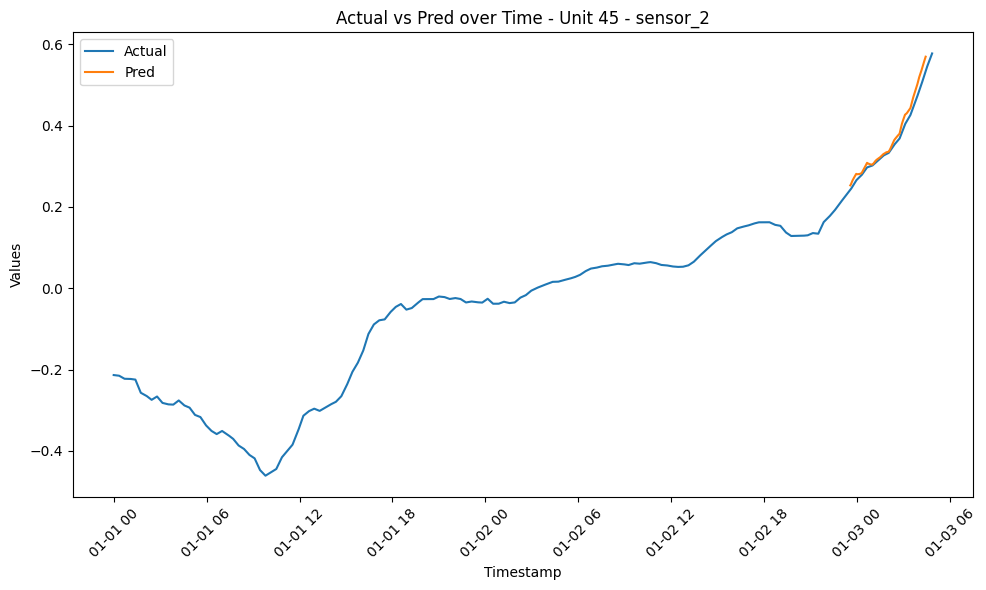

RMSE for Unit 45 - sensor_2: 0.012575106949098016


  0%|          | 0/91 [00:00<?, ?it/s]

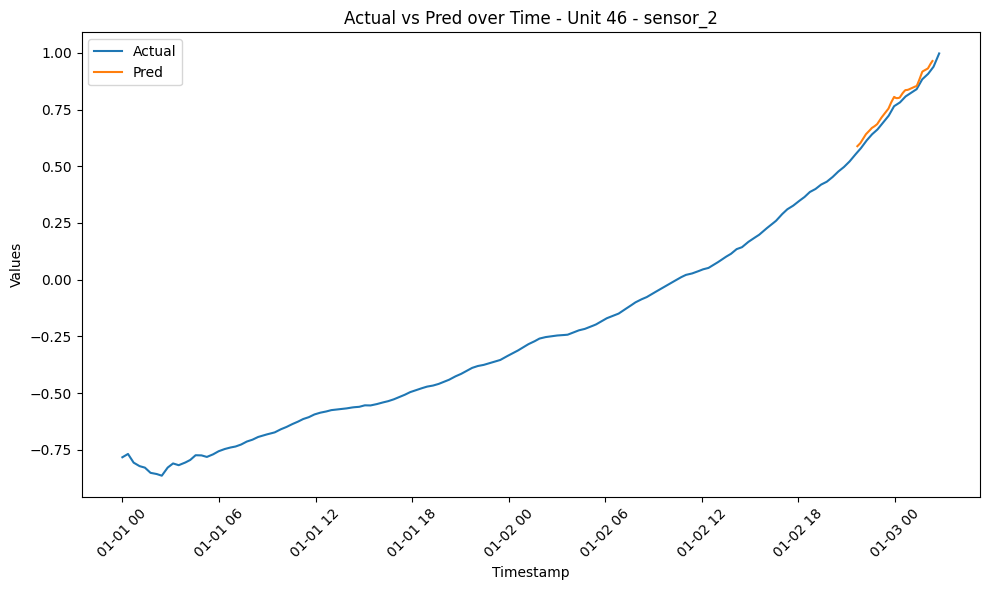

RMSE for Unit 46 - sensor_2: 0.011796766277742708


  0%|          | 0/78 [00:00<?, ?it/s]

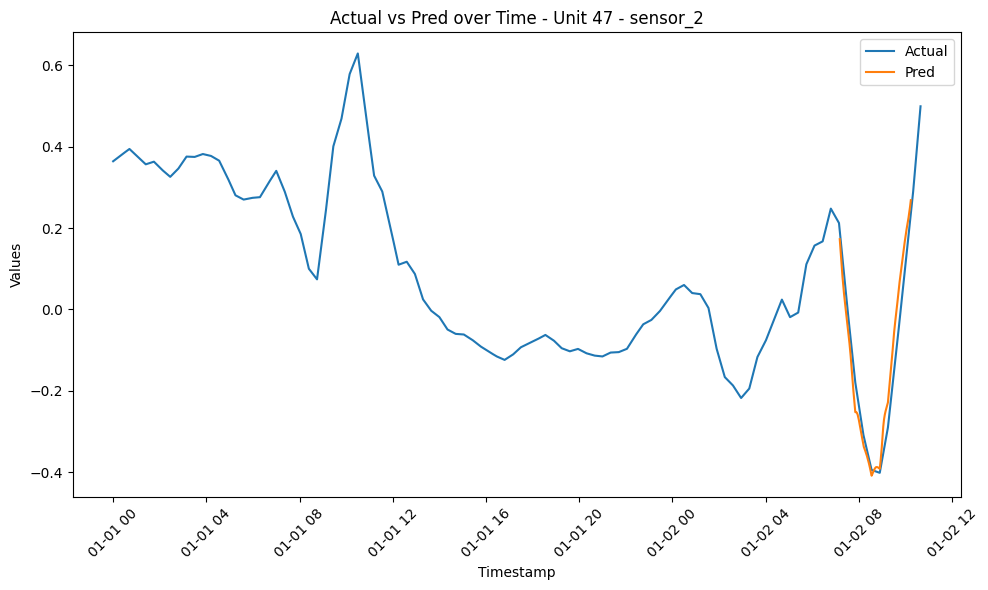

RMSE for Unit 47 - sensor_2: 0.12455366655407488


  0%|          | 0/78 [00:00<?, ?it/s]

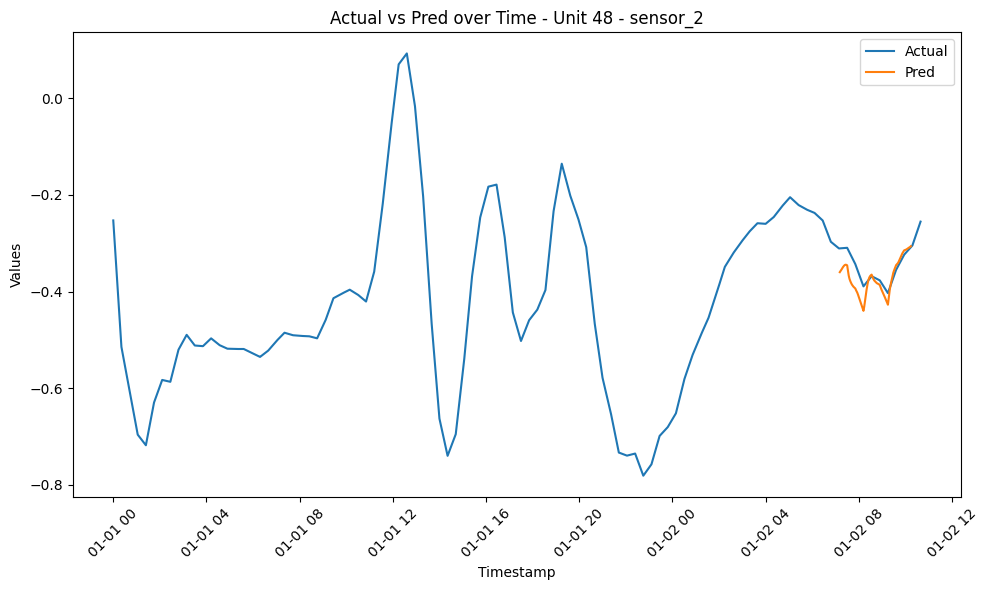

RMSE for Unit 48 - sensor_2: 0.03189868927070898


  0%|          | 0/132 [00:00<?, ?it/s]

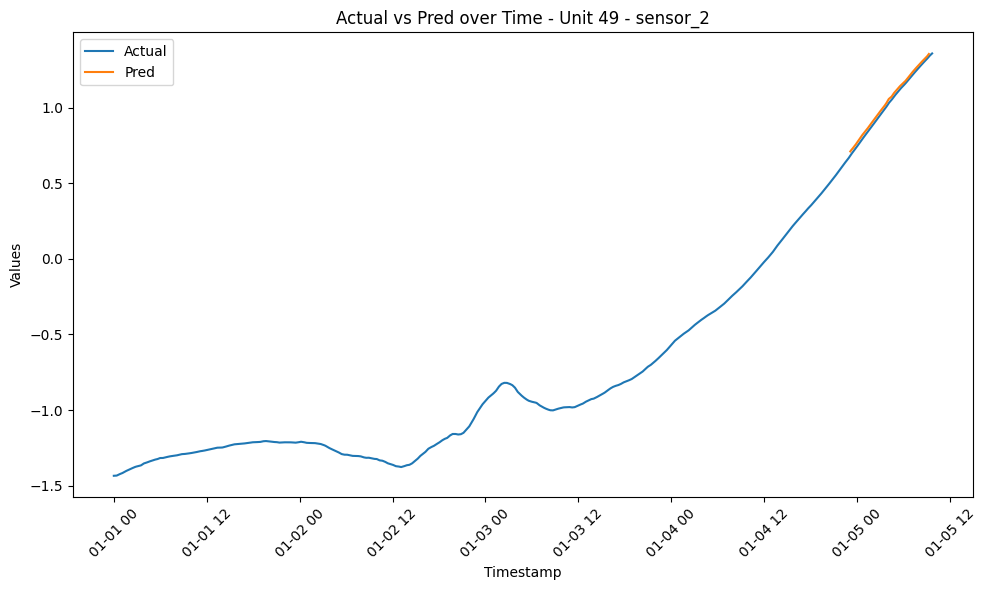

RMSE for Unit 49 - sensor_2: 0.004207874050452105


  0%|          | 0/78 [00:00<?, ?it/s]

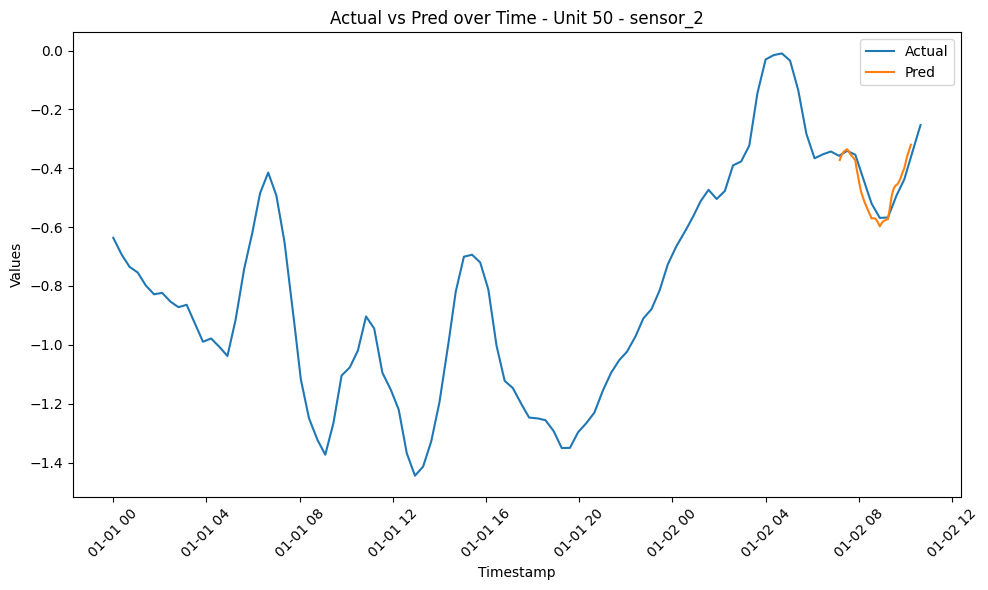

RMSE for Unit 50 - sensor_2: 0.04554444408414307


  0%|          | 0/90 [00:00<?, ?it/s]

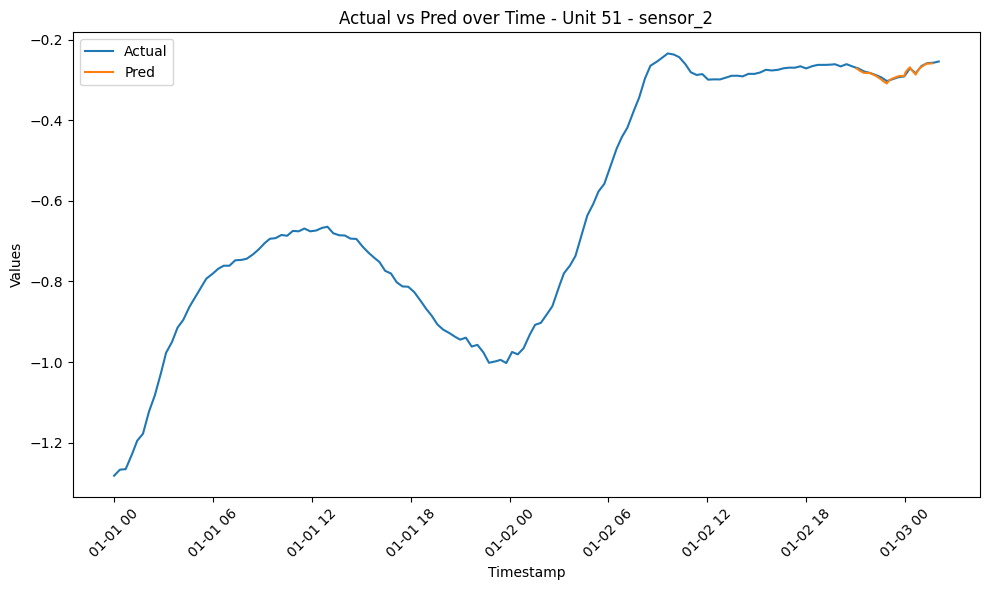

RMSE for Unit 51 - sensor_2: 0.007897886910910453


  0%|          | 0/102 [00:00<?, ?it/s]

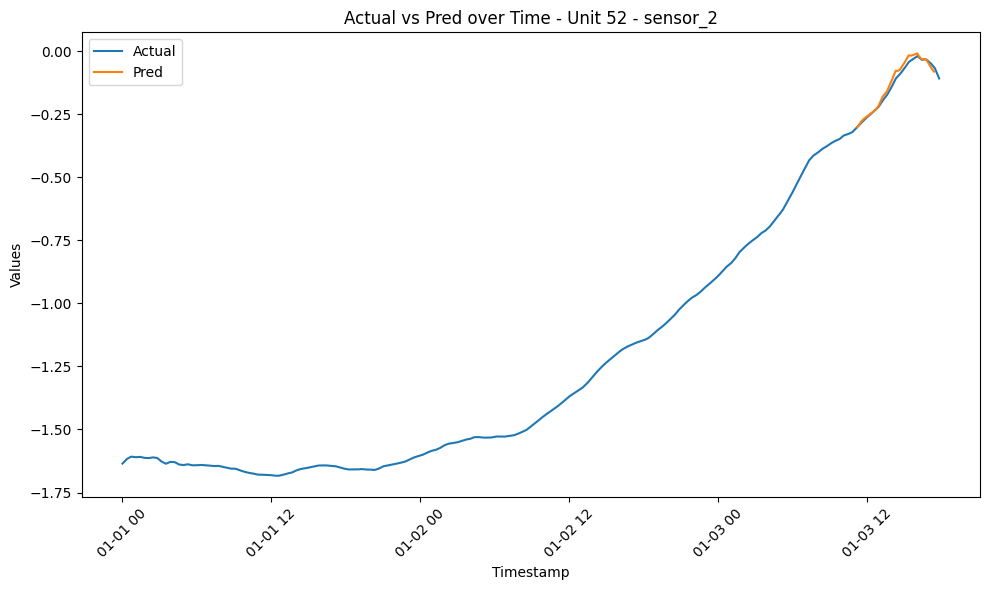

RMSE for Unit 52 - sensor_2: 0.014309828757812842


  0%|          | 0/95 [00:00<?, ?it/s]

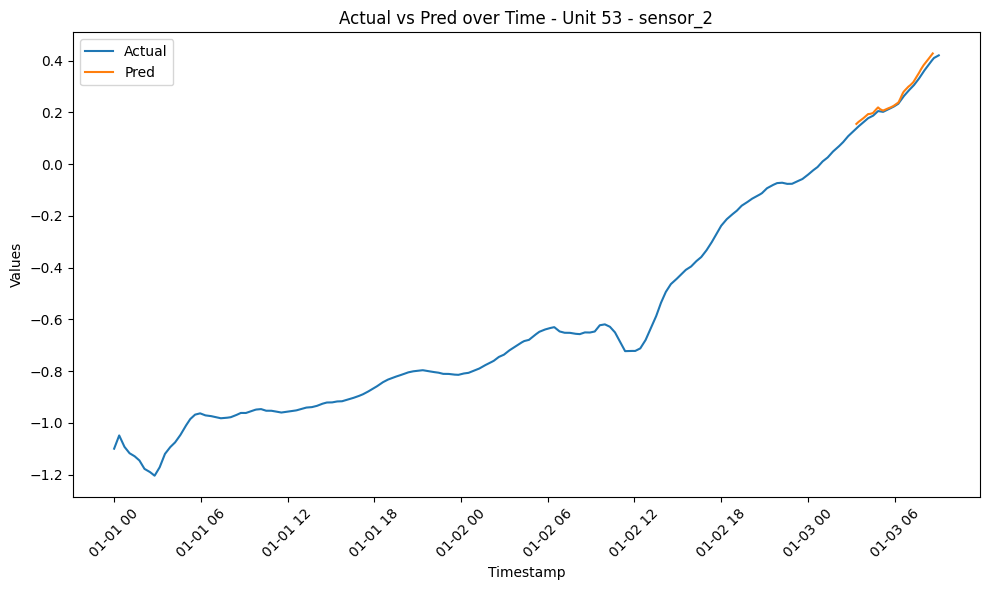

RMSE for Unit 53 - sensor_2: 0.010089940308995425


  0%|          | 0/84 [00:00<?, ?it/s]

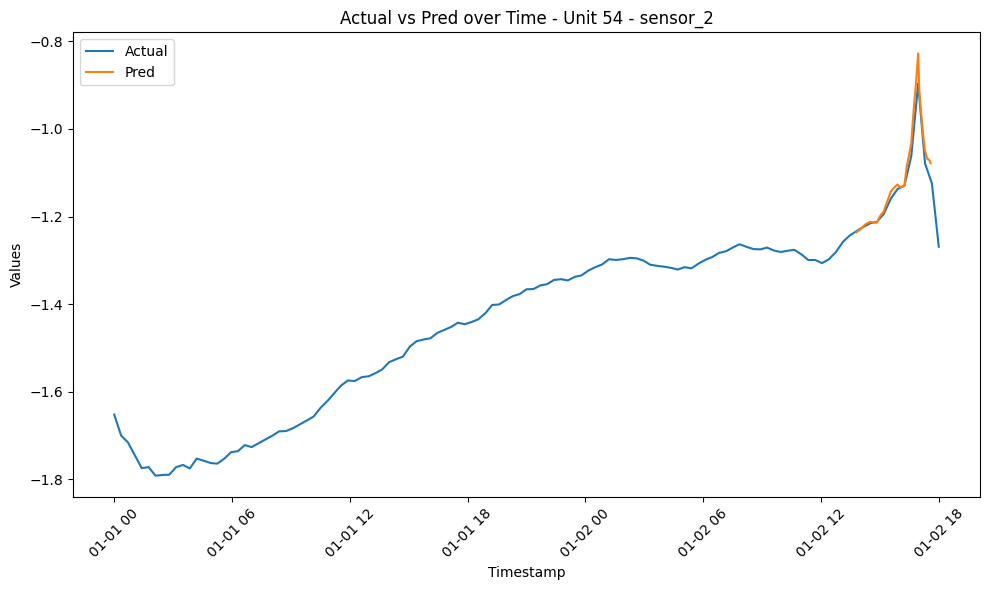

RMSE for Unit 54 - sensor_2: 0.08319827367366875


  0%|          | 0/82 [00:00<?, ?it/s]

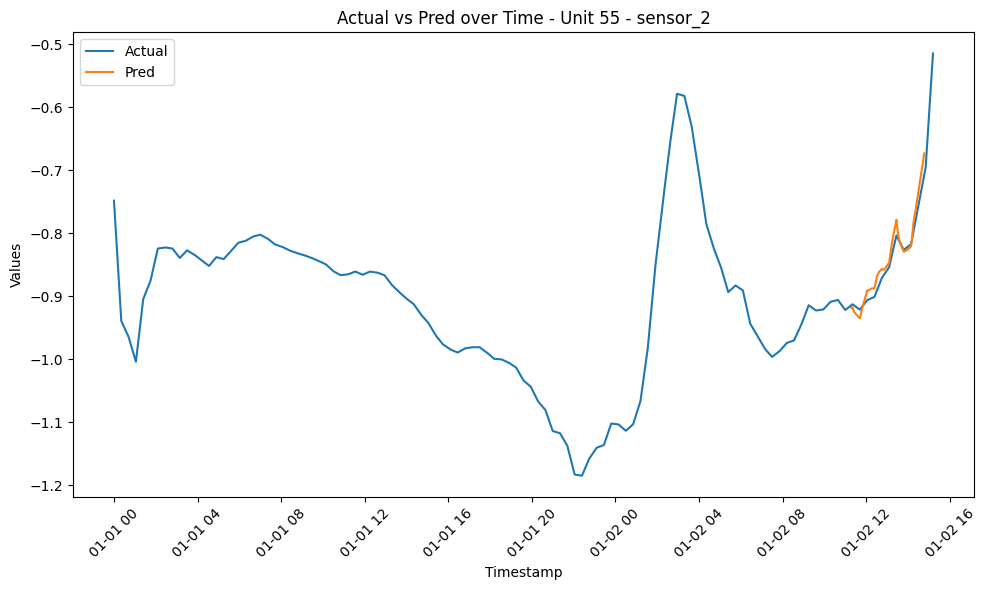

RMSE for Unit 55 - sensor_2: 0.043694360619741315


  0%|          | 0/88 [00:00<?, ?it/s]

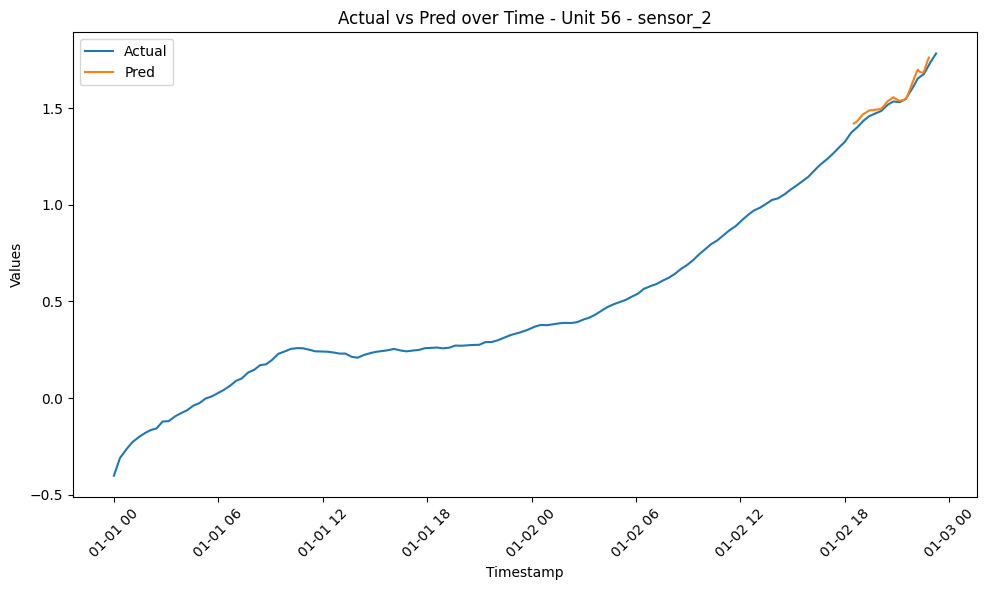

RMSE for Unit 56 - sensor_2: 0.02459190712357927


  0%|          | 0/94 [00:00<?, ?it/s]

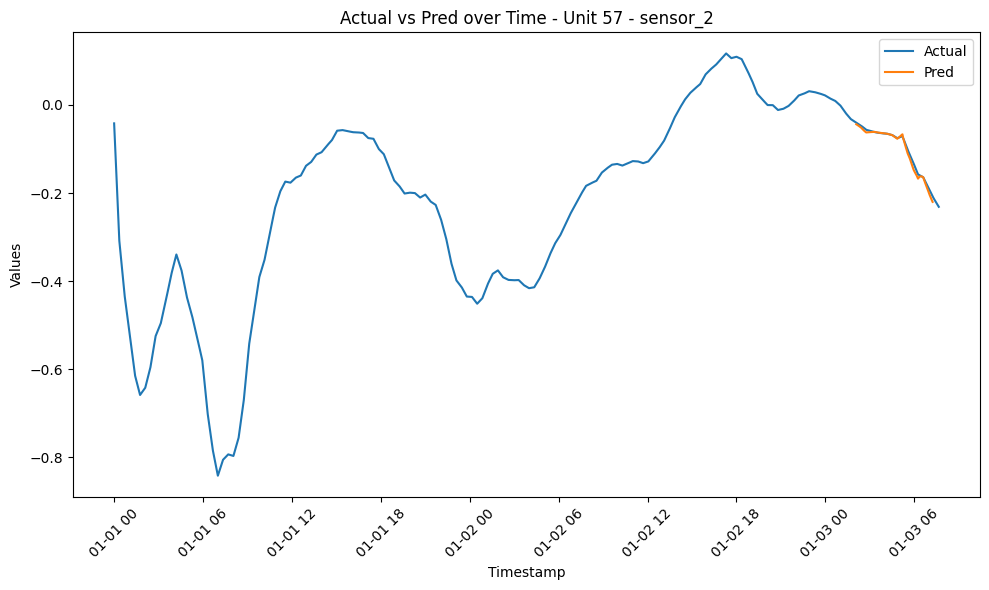

RMSE for Unit 57 - sensor_2: 0.014224223533061355


  0%|          | 0/98 [00:00<?, ?it/s]

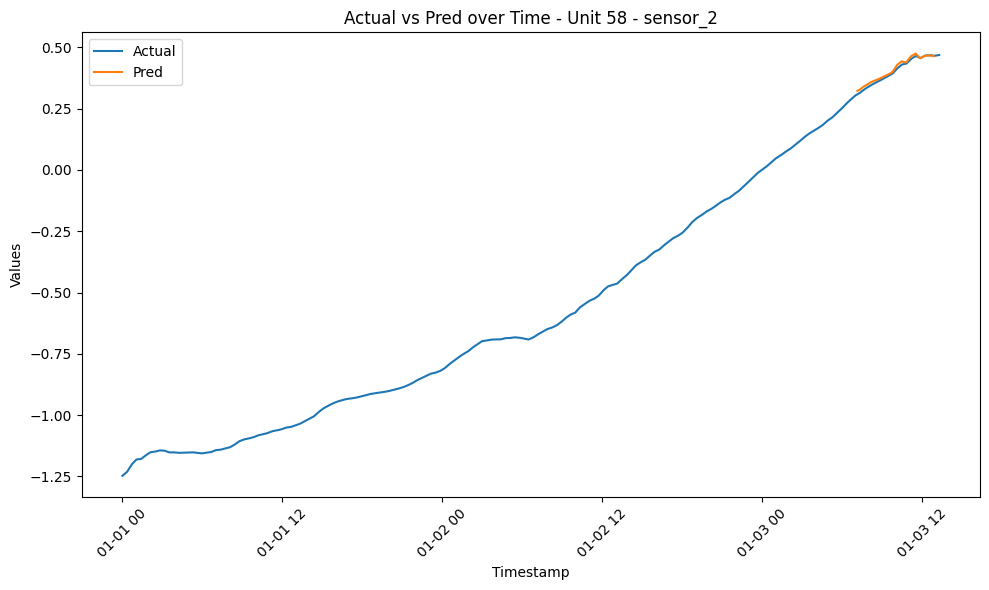

RMSE for Unit 58 - sensor_2: 0.006760208644913292


  0%|          | 0/78 [00:00<?, ?it/s]

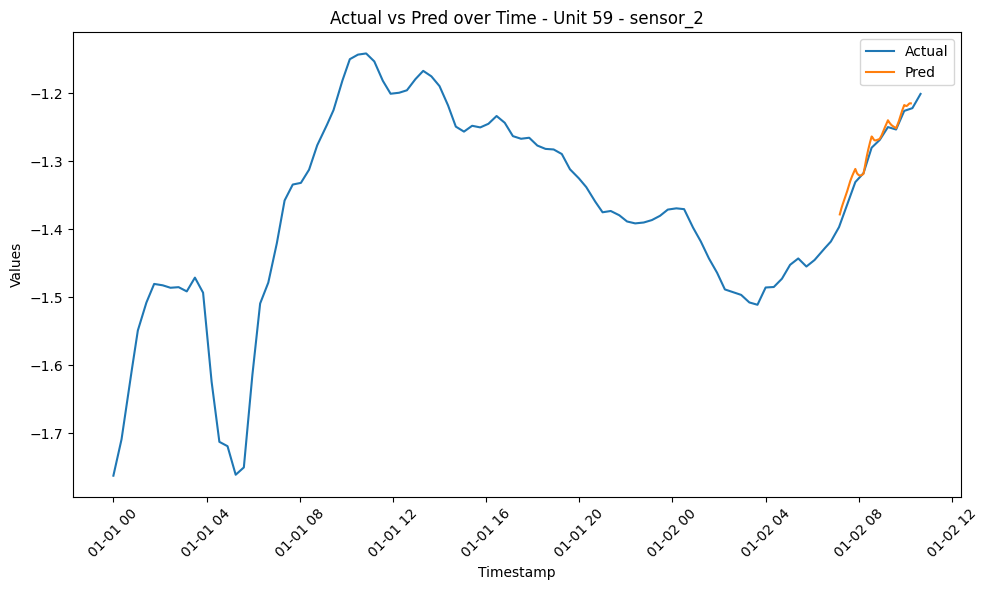

RMSE for Unit 59 - sensor_2: 0.016329463533073227


  0%|          | 0/91 [00:00<?, ?it/s]

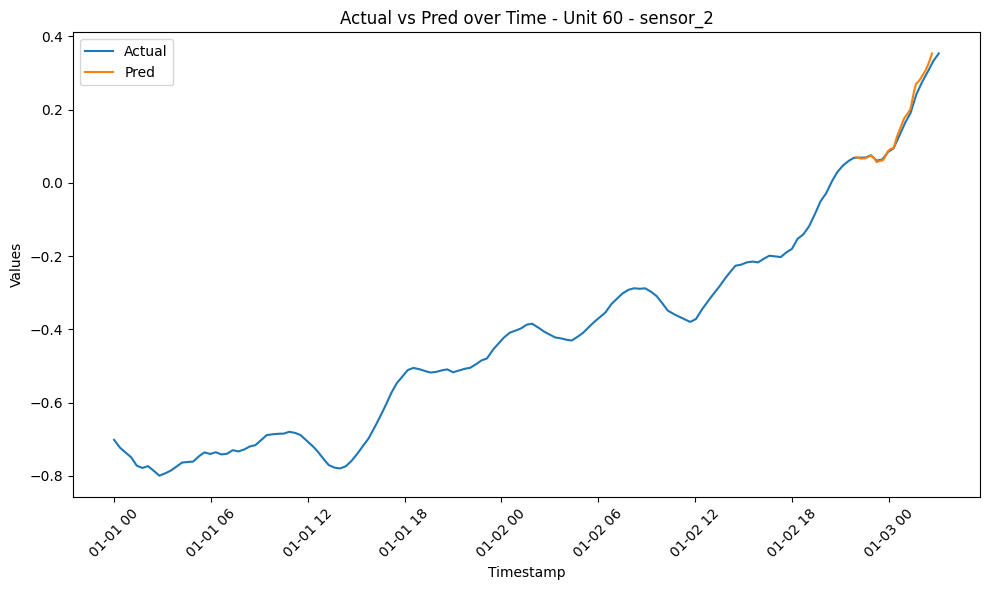

RMSE for Unit 60 - sensor_2: 0.01945993461498316


  0%|          | 0/94 [00:00<?, ?it/s]

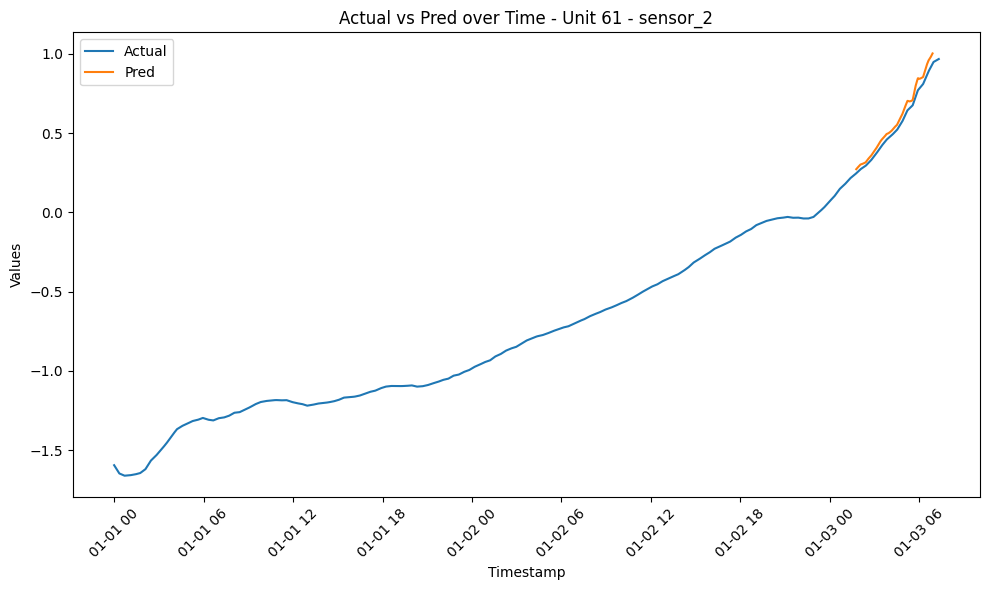

RMSE for Unit 61 - sensor_2: 0.021529733753000515


  0%|          | 0/113 [00:00<?, ?it/s]

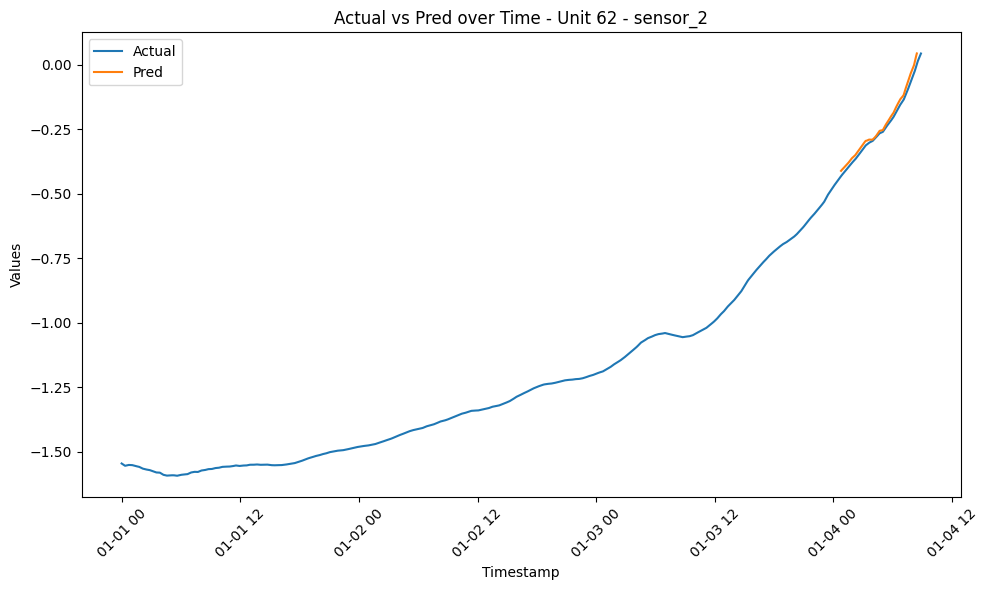

RMSE for Unit 62 - sensor_2: 0.008148373921171572


  0%|          | 0/93 [00:00<?, ?it/s]

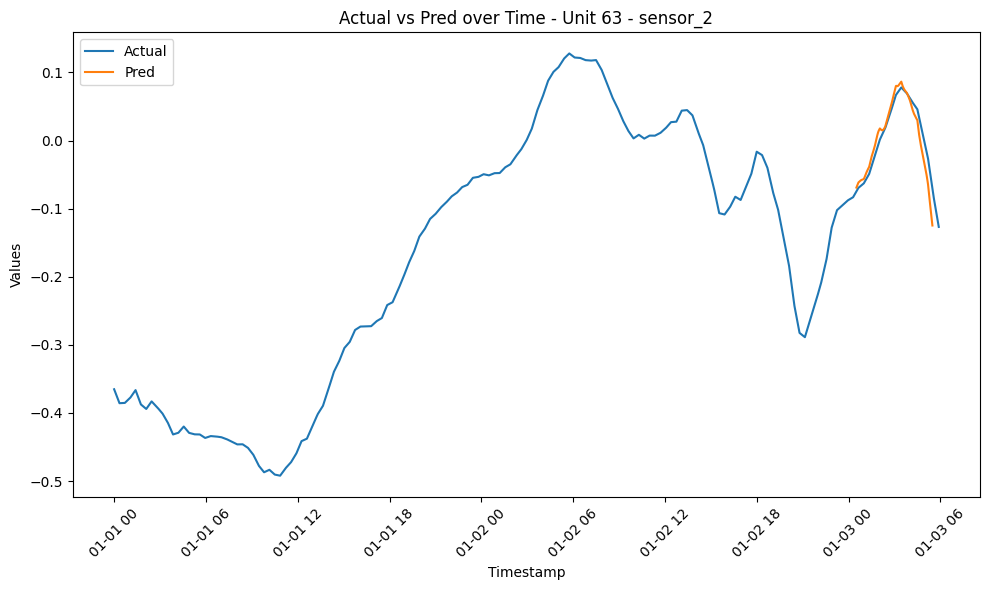

RMSE for Unit 63 - sensor_2: 0.014600007432249477


  0%|          | 0/96 [00:00<?, ?it/s]

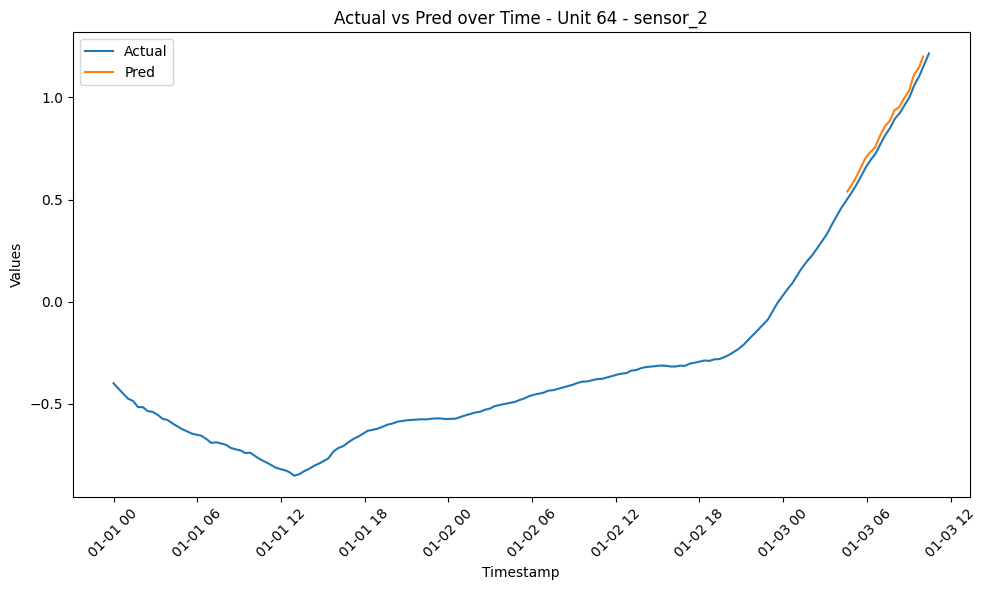

RMSE for Unit 64 - sensor_2: 0.010615438893869726


  0%|          | 0/78 [00:00<?, ?it/s]

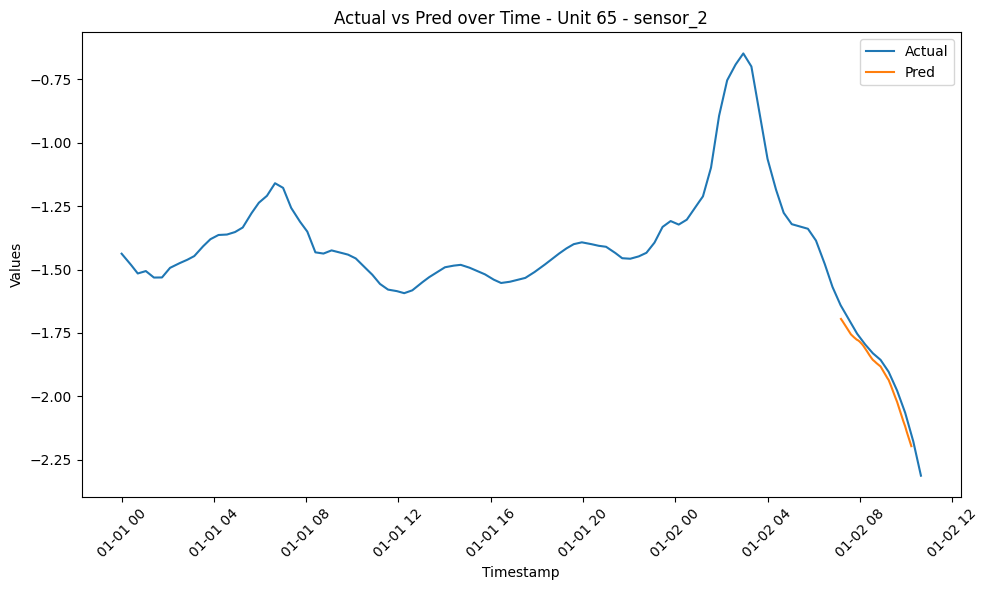

RMSE for Unit 65 - sensor_2: 0.04481484550214819


  0%|          | 0/91 [00:00<?, ?it/s]

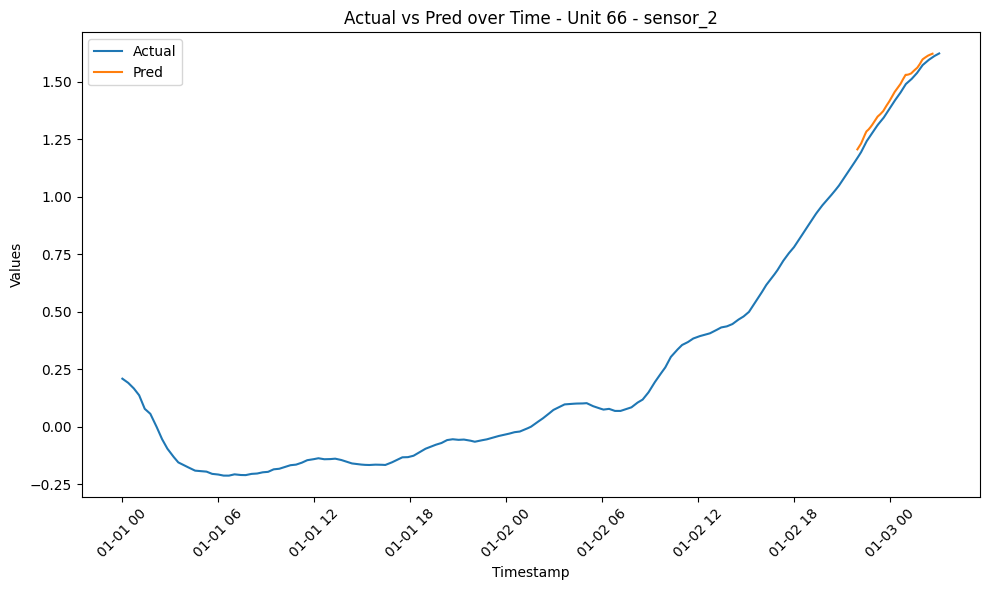

RMSE for Unit 66 - sensor_2: 0.0076223399381013385


  0%|          | 0/78 [00:00<?, ?it/s]

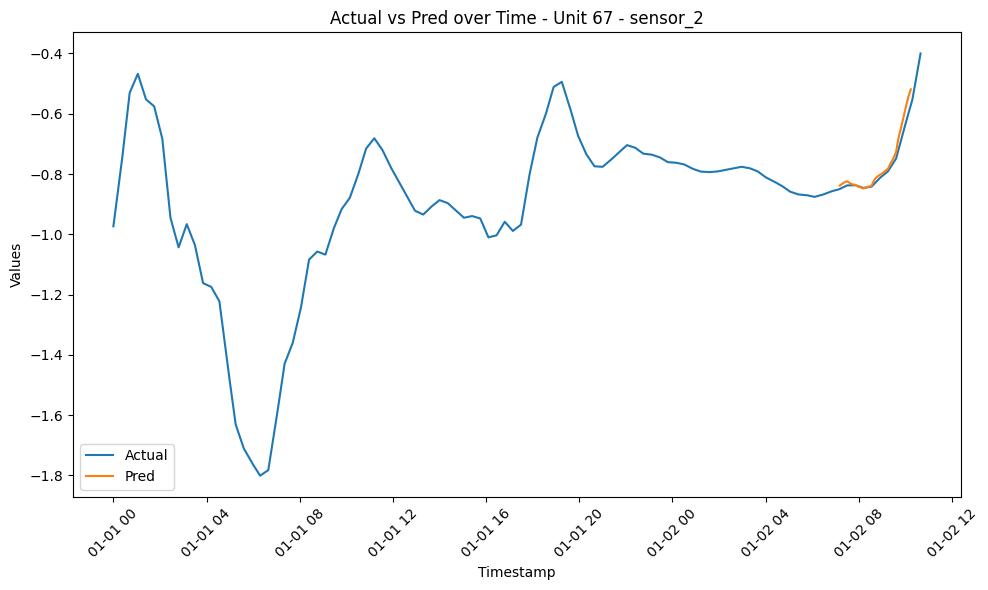

RMSE for Unit 67 - sensor_2: 0.04674357432064948


  0%|          | 0/101 [00:00<?, ?it/s]

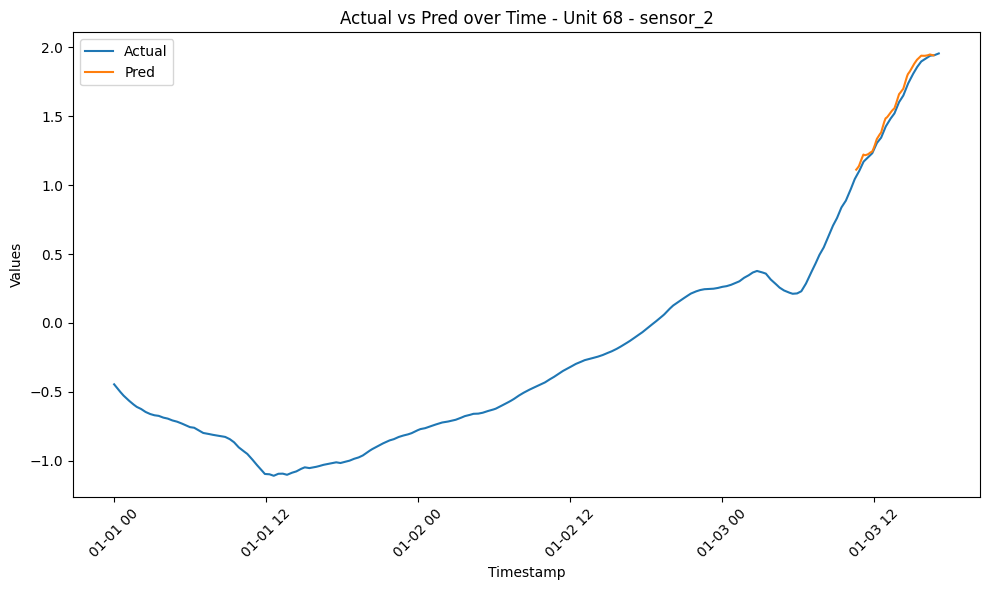

RMSE for Unit 68 - sensor_2: 0.025054208019463224


  0%|          | 0/78 [00:00<?, ?it/s]

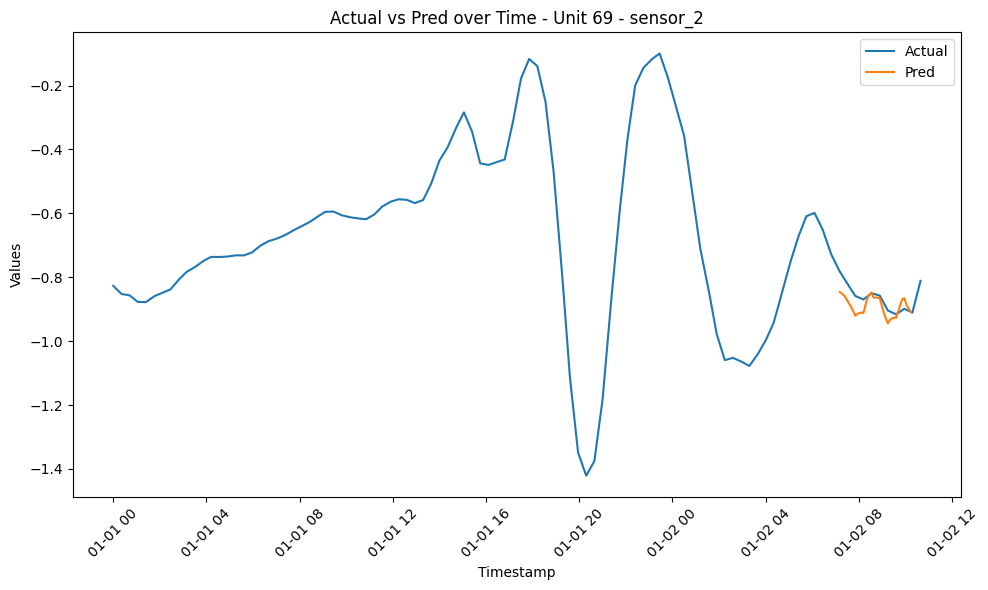

RMSE for Unit 69 - sensor_2: 0.03328192852928092


  0%|          | 0/92 [00:00<?, ?it/s]

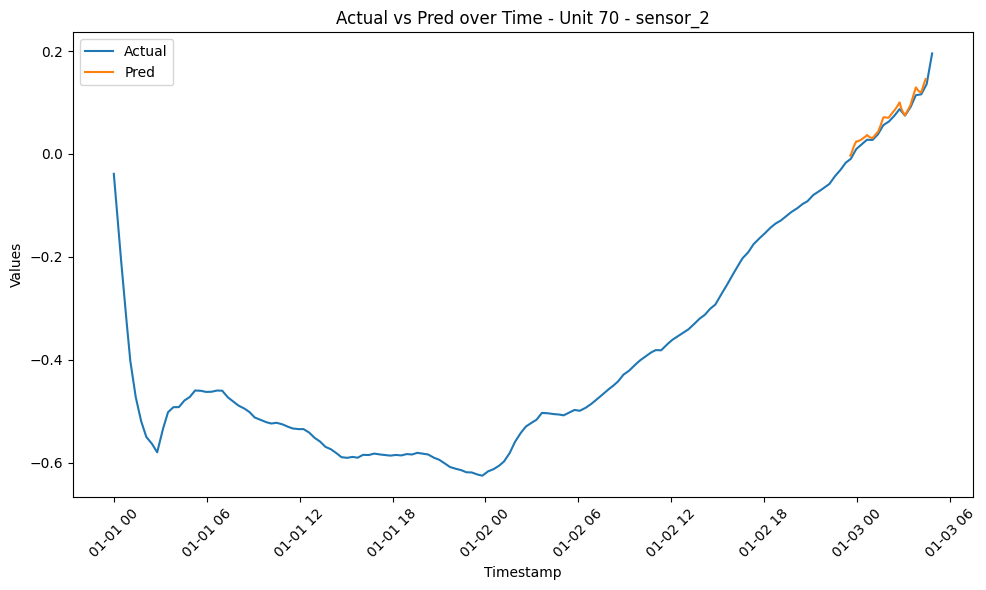

RMSE for Unit 70 - sensor_2: 0.013246201736760969


  0%|          | 0/78 [00:00<?, ?it/s]

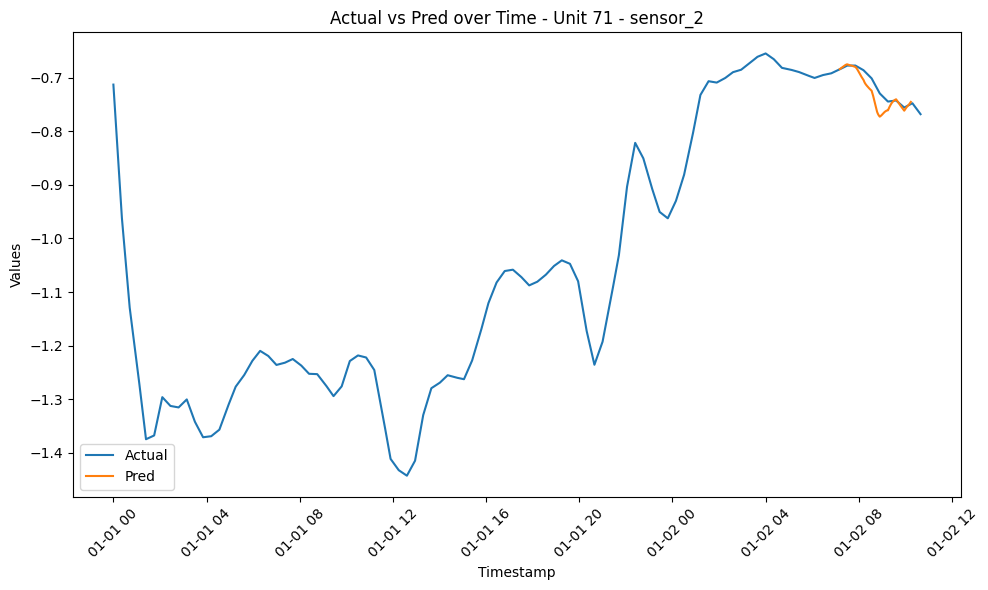

RMSE for Unit 71 - sensor_2: 0.011589933256476526


  0%|          | 0/87 [00:00<?, ?it/s]

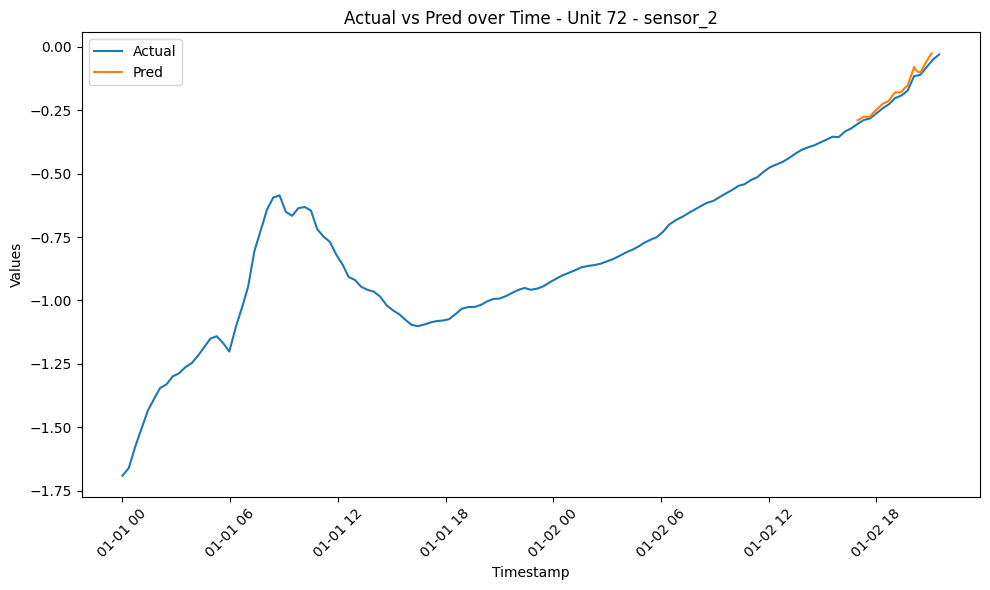

RMSE for Unit 72 - sensor_2: 0.013409398027991326


  0%|          | 0/82 [00:00<?, ?it/s]

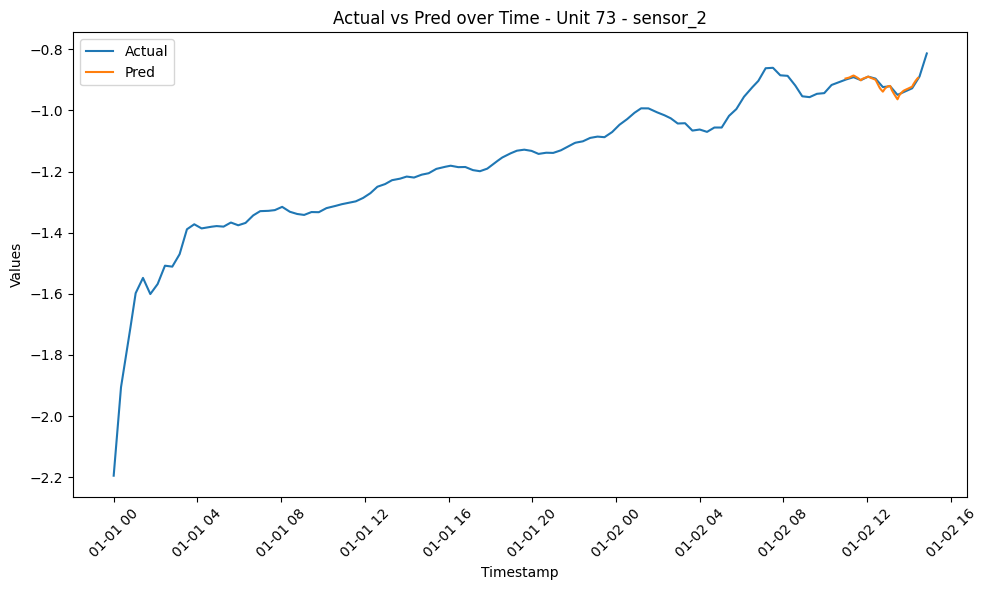

RMSE for Unit 73 - sensor_2: 0.02269981639438219


  0%|          | 0/88 [00:00<?, ?it/s]

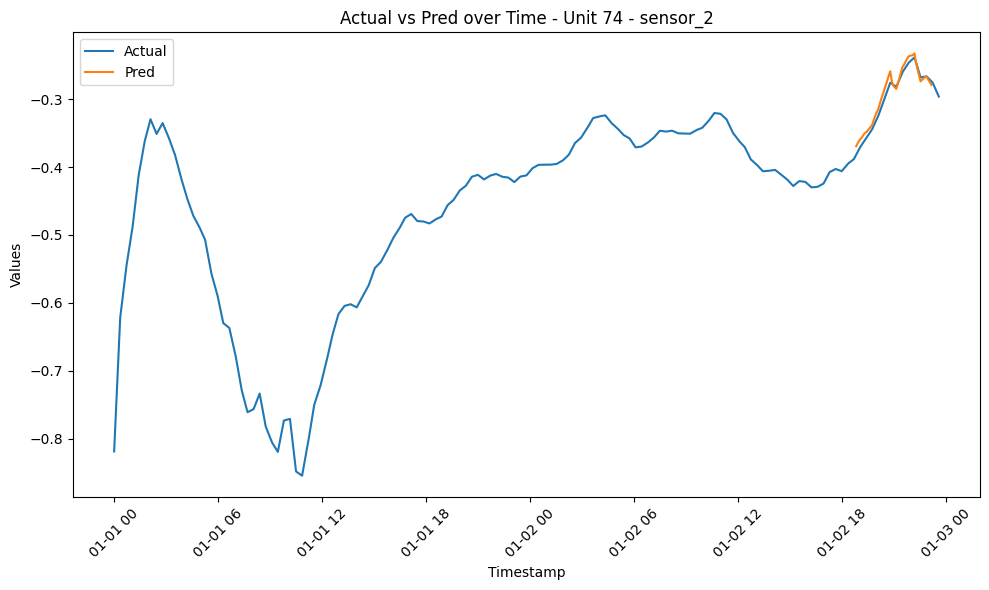

RMSE for Unit 74 - sensor_2: 0.013950915368262207


  0%|          | 0/78 [00:00<?, ?it/s]

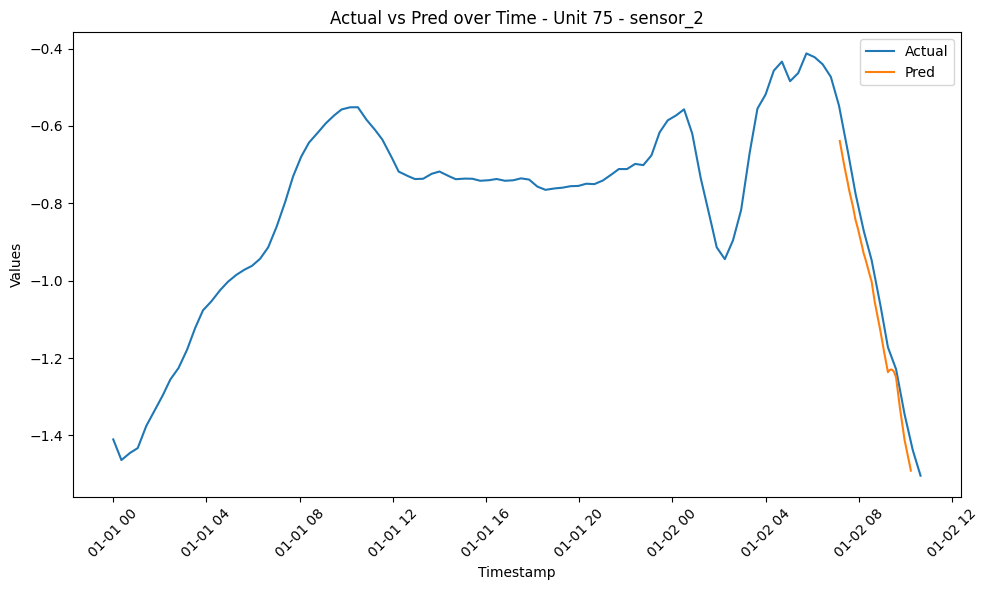

RMSE for Unit 75 - sensor_2: 0.05273061802663441


  0%|          | 0/106 [00:00<?, ?it/s]

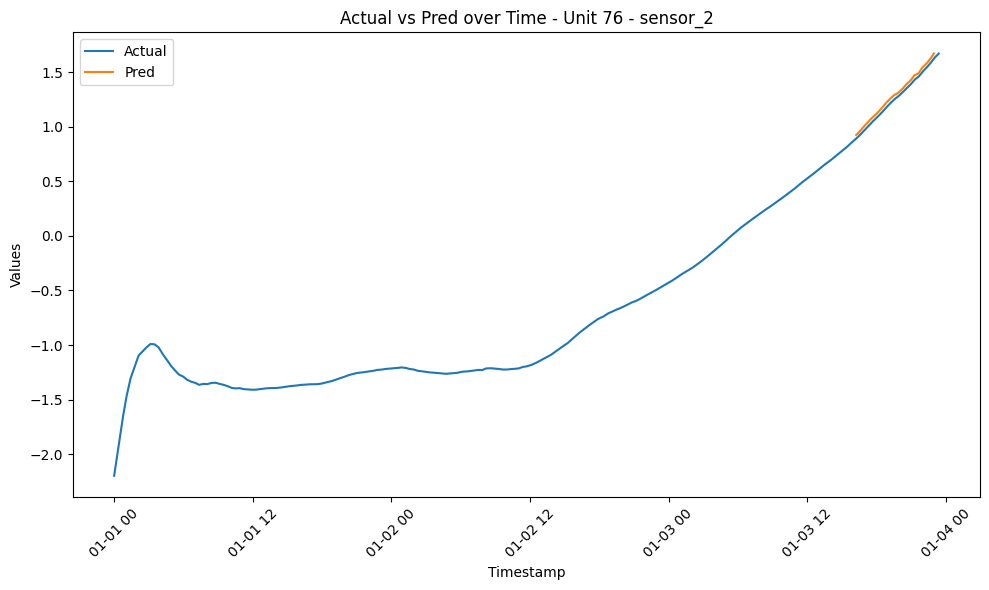

RMSE for Unit 76 - sensor_2: 0.007271664800379961


  0%|          | 0/95 [00:00<?, ?it/s]

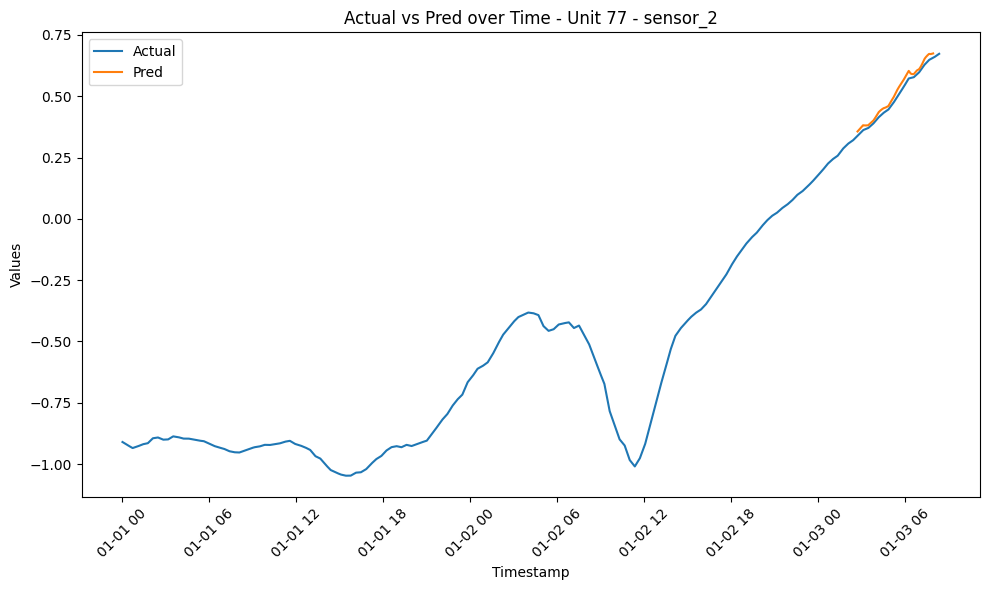

RMSE for Unit 77 - sensor_2: 0.010550599403276704


  0%|          | 0/78 [00:00<?, ?it/s]

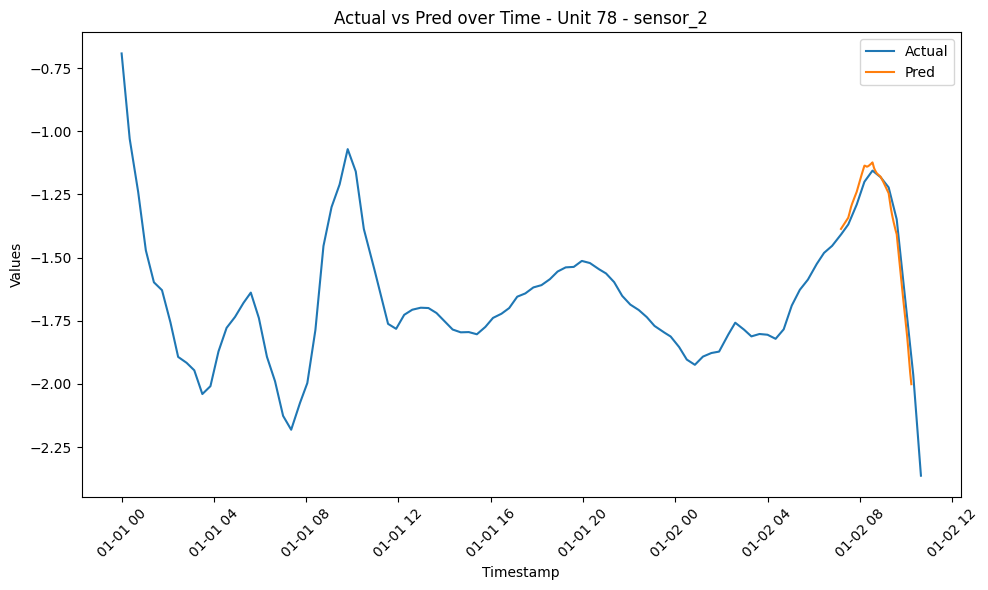

RMSE for Unit 78 - sensor_2: 0.15814392196064048


  0%|          | 0/79 [00:00<?, ?it/s]

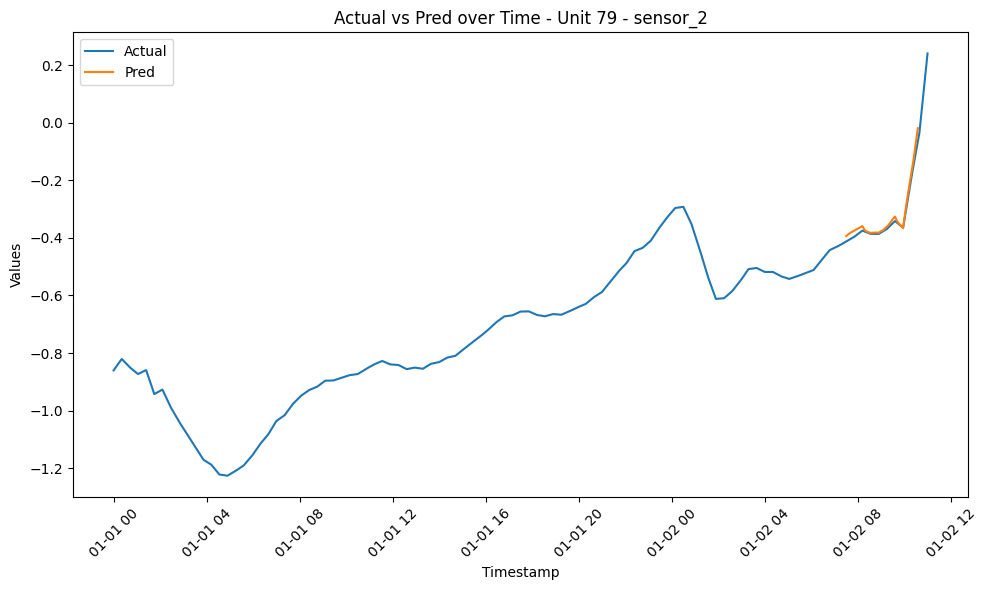

RMSE for Unit 79 - sensor_2: 0.09816698069775072


  0%|          | 0/87 [00:00<?, ?it/s]

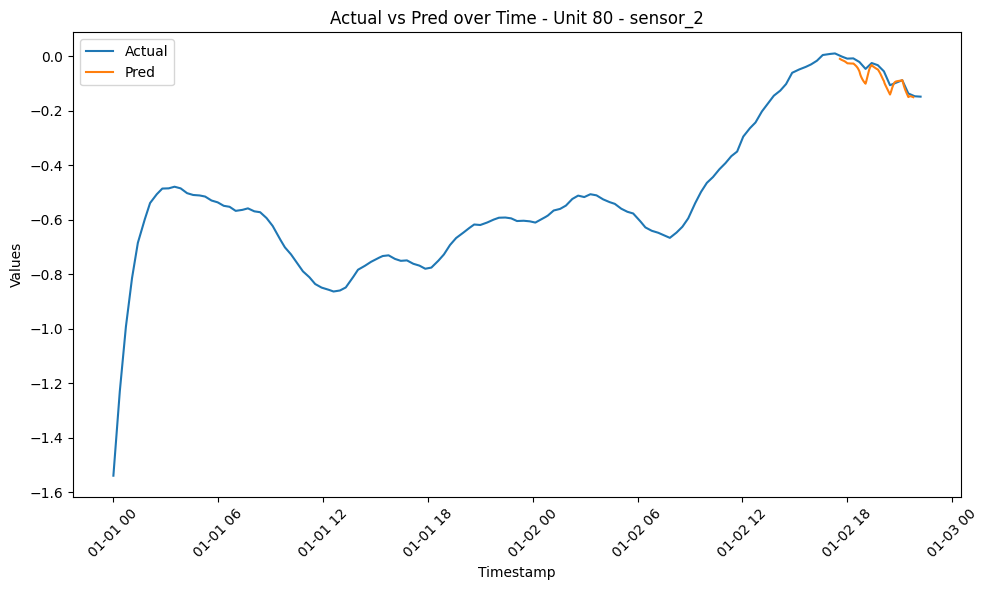

RMSE for Unit 80 - sensor_2: 0.025386700932666793


  0%|          | 0/108 [00:00<?, ?it/s]

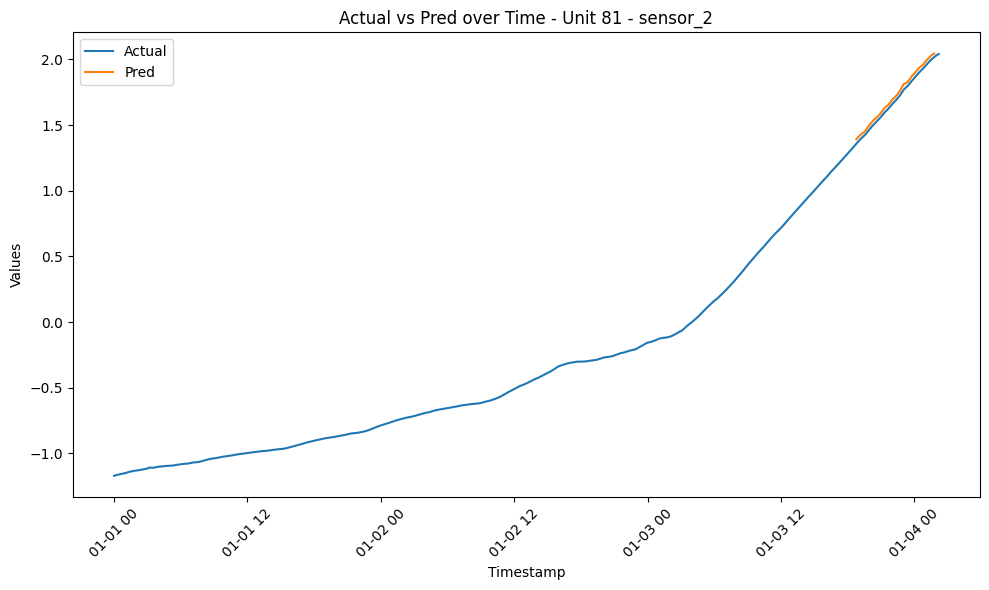

RMSE for Unit 81 - sensor_2: 0.006797957129645247


  0%|          | 0/95 [00:00<?, ?it/s]

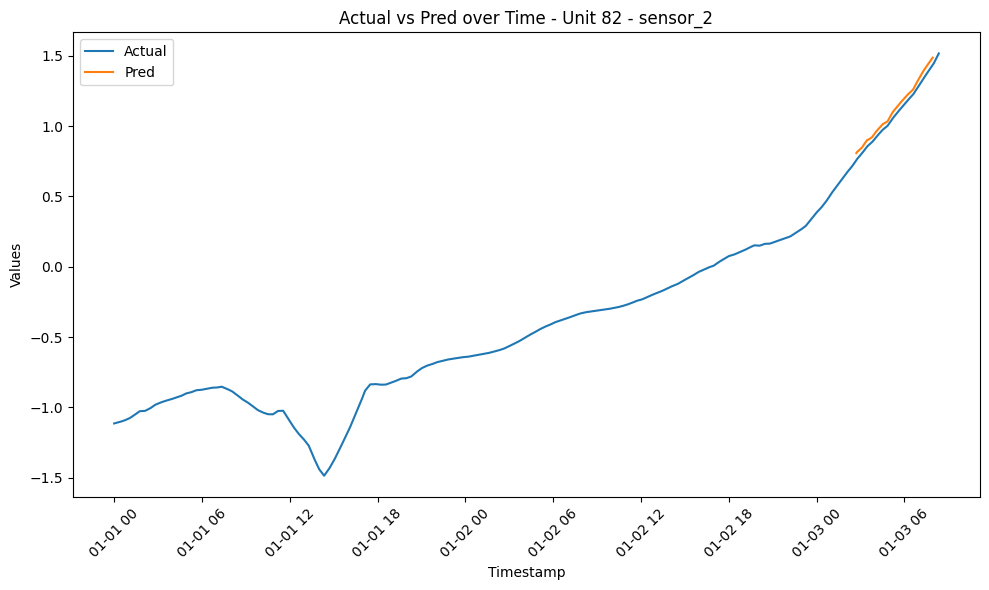

RMSE for Unit 82 - sensor_2: 0.012330193141655189


  0%|          | 0/78 [00:00<?, ?it/s]

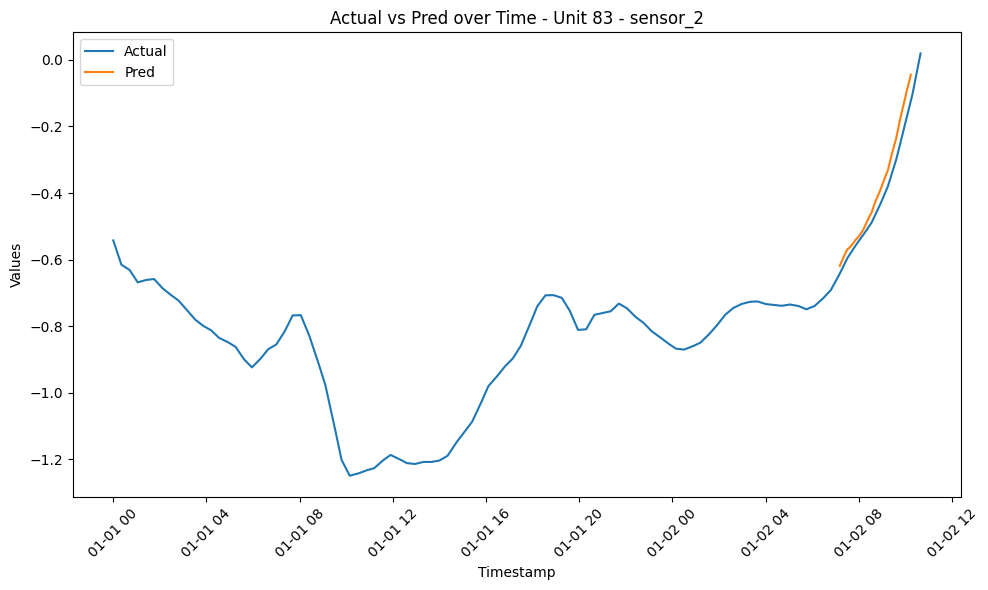

RMSE for Unit 83 - sensor_2: 0.03308748521529158


  0%|          | 0/97 [00:00<?, ?it/s]

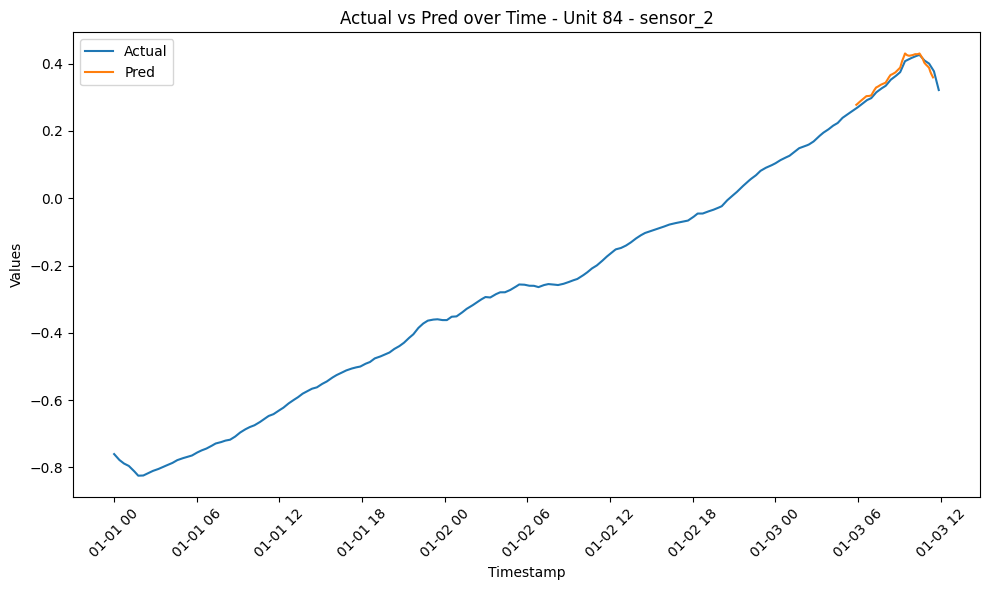

RMSE for Unit 84 - sensor_2: 0.010044791938279384


  0%|          | 0/78 [00:00<?, ?it/s]

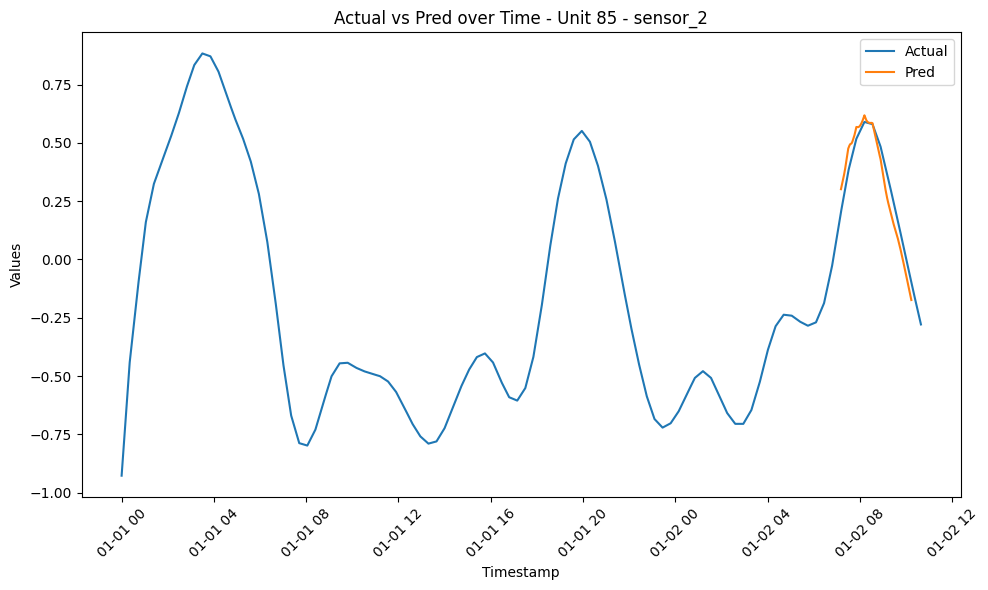

RMSE for Unit 85 - sensor_2: 0.08614089652620438


  0%|          | 0/81 [00:00<?, ?it/s]

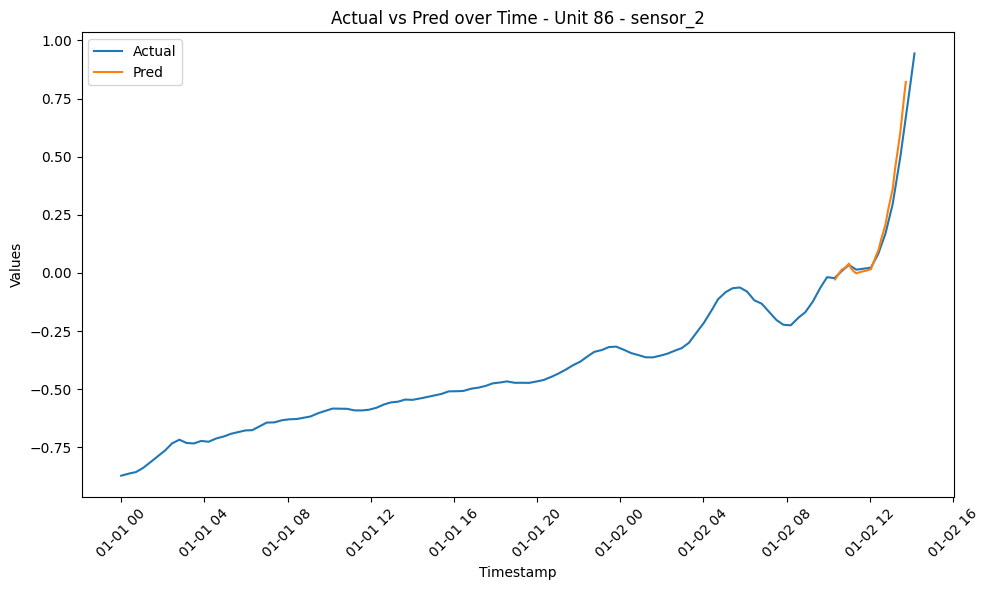

RMSE for Unit 86 - sensor_2: 0.08753547750469333


  0%|          | 0/78 [00:00<?, ?it/s]

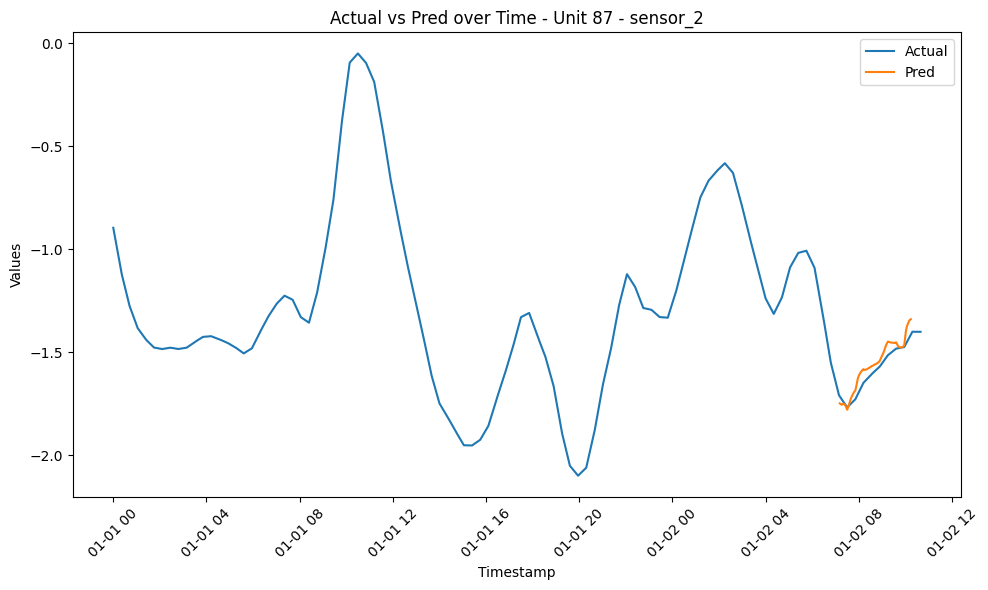

RMSE for Unit 87 - sensor_2: 0.03198596546876536


  0%|          | 0/78 [00:00<?, ?it/s]

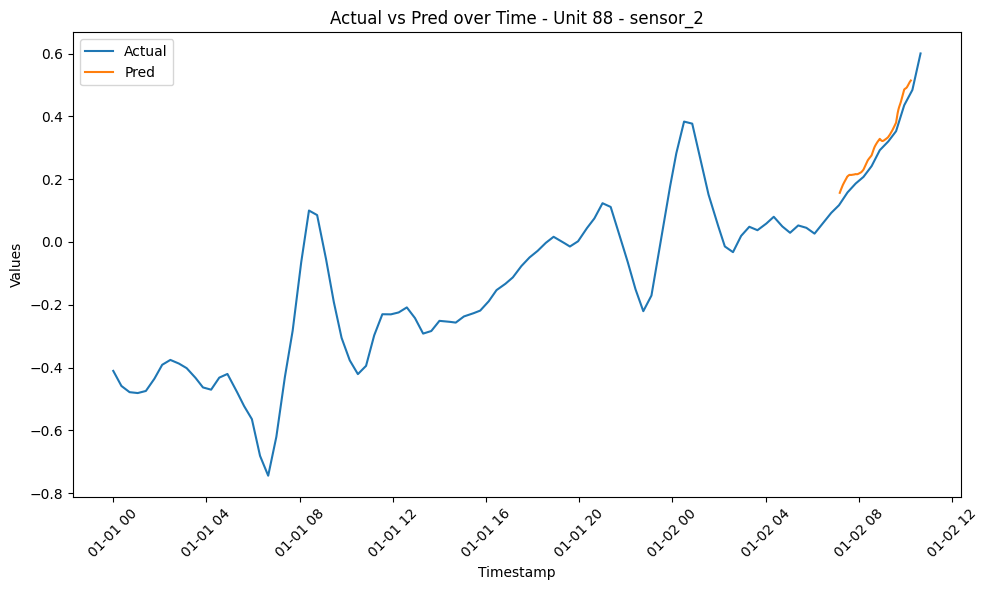

RMSE for Unit 88 - sensor_2: 0.028935355916654366


  0%|          | 0/99 [00:00<?, ?it/s]

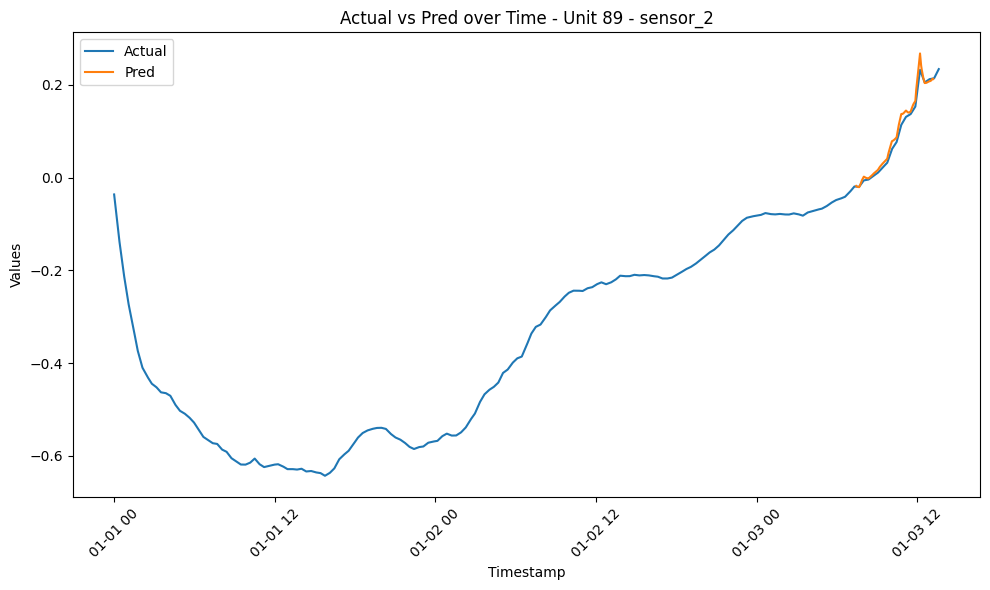

RMSE for Unit 89 - sensor_2: 0.019320781839861686


  0%|          | 0/91 [00:00<?, ?it/s]

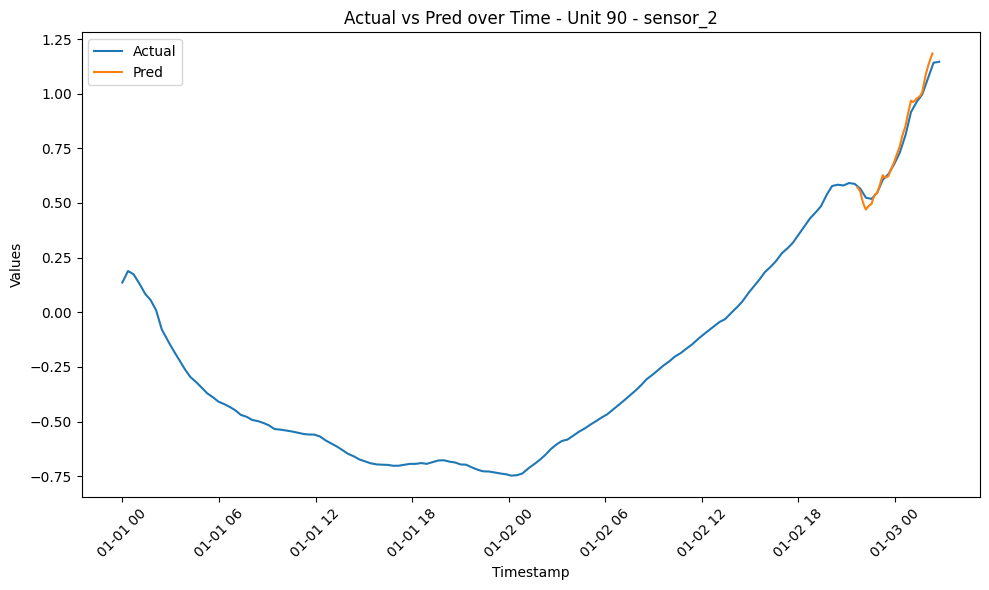

RMSE for Unit 90 - sensor_2: 0.047008521600699495


  0%|          | 0/114 [00:00<?, ?it/s]

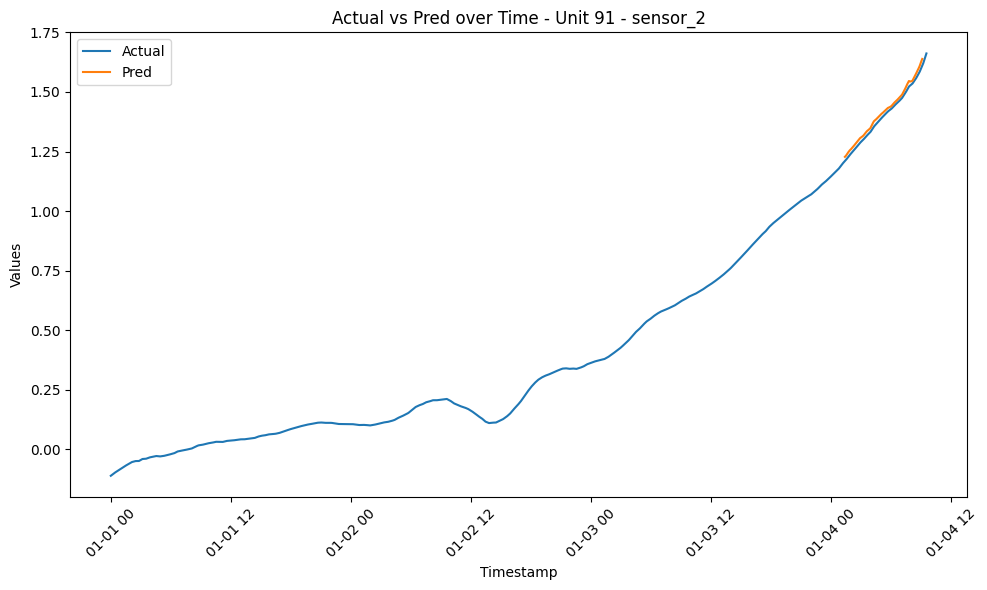

RMSE for Unit 91 - sensor_2: 0.006603103649617787


  0%|          | 0/92 [00:00<?, ?it/s]

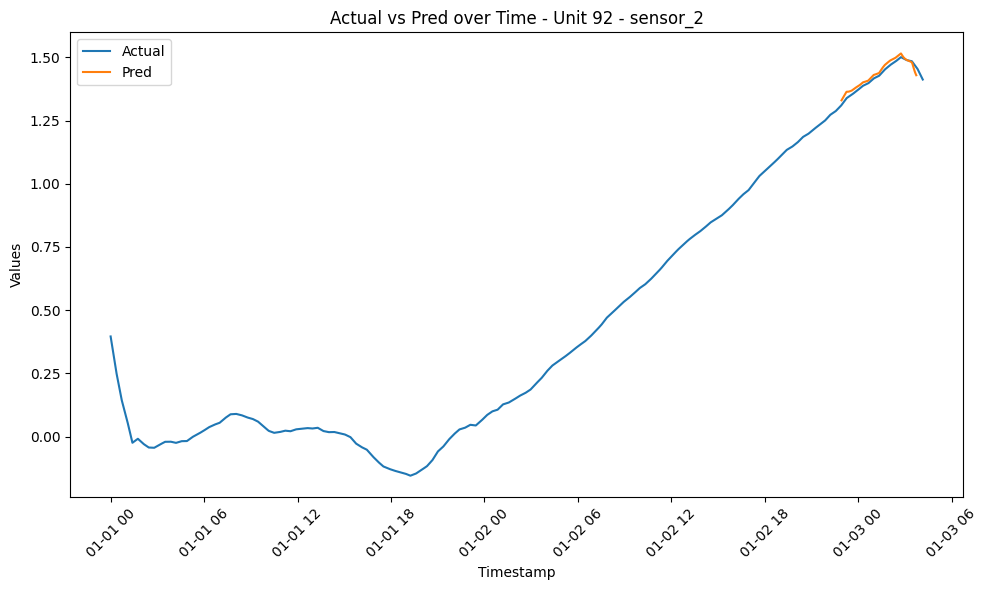

RMSE for Unit 92 - sensor_2: 0.010890748637700018


  0%|          | 0/116 [00:00<?, ?it/s]

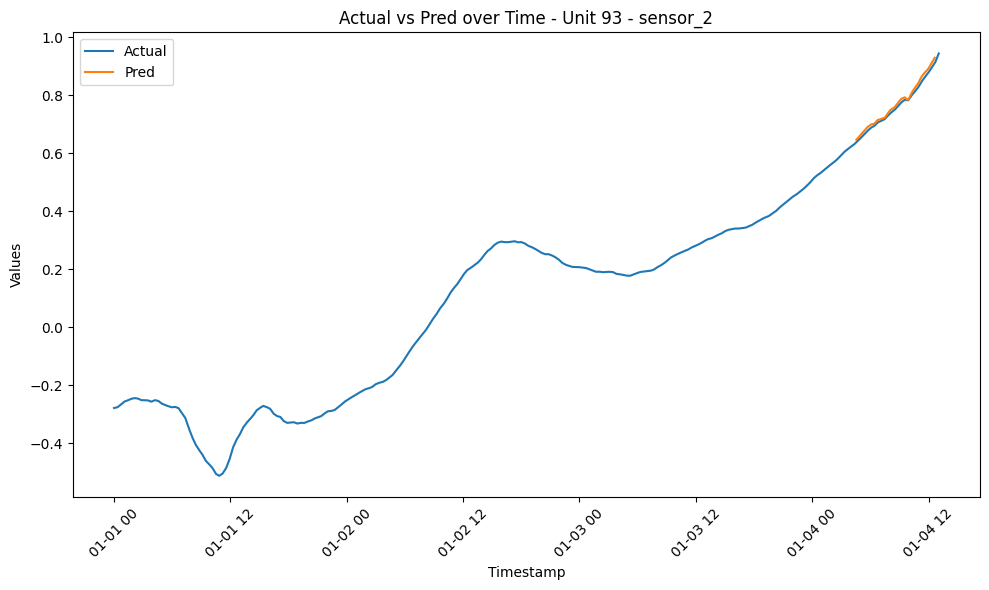

RMSE for Unit 93 - sensor_2: 0.005610159925143201


  0%|          | 0/87 [00:00<?, ?it/s]

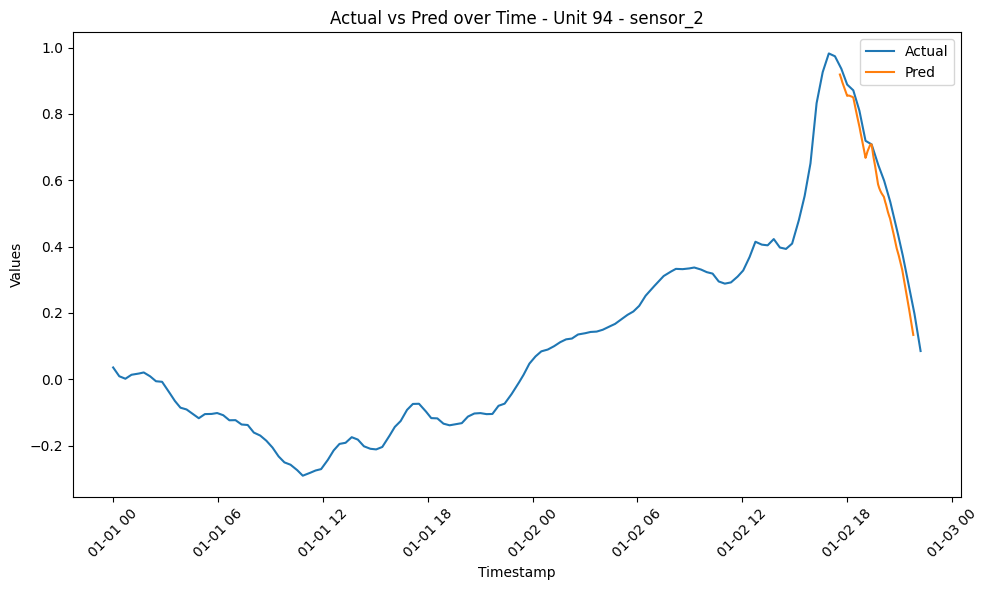

RMSE for Unit 94 - sensor_2: 0.035071927068197485


  0%|          | 0/78 [00:00<?, ?it/s]

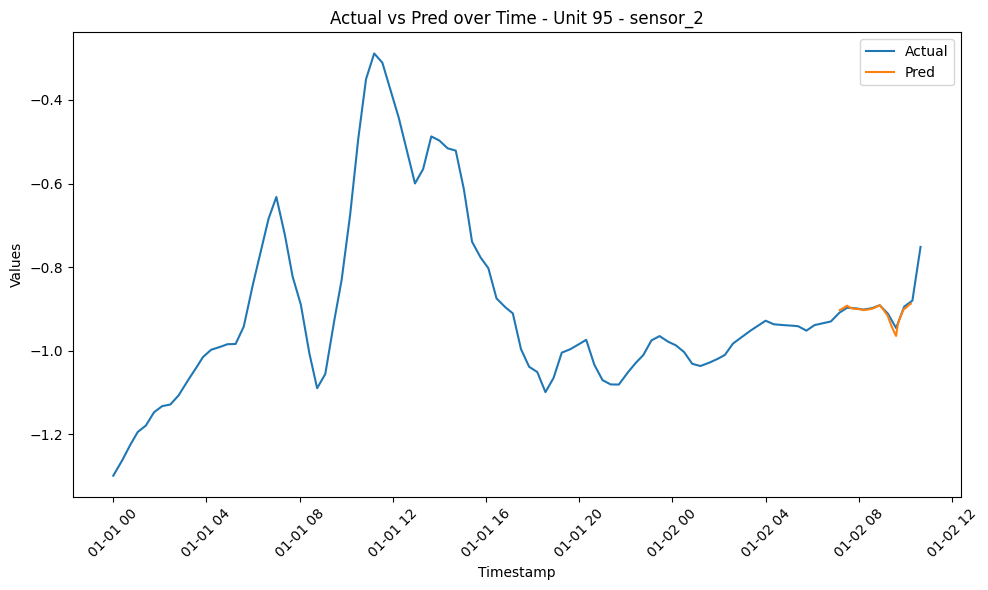

RMSE for Unit 95 - sensor_2: 0.035629985242418116


  0%|          | 0/78 [00:00<?, ?it/s]

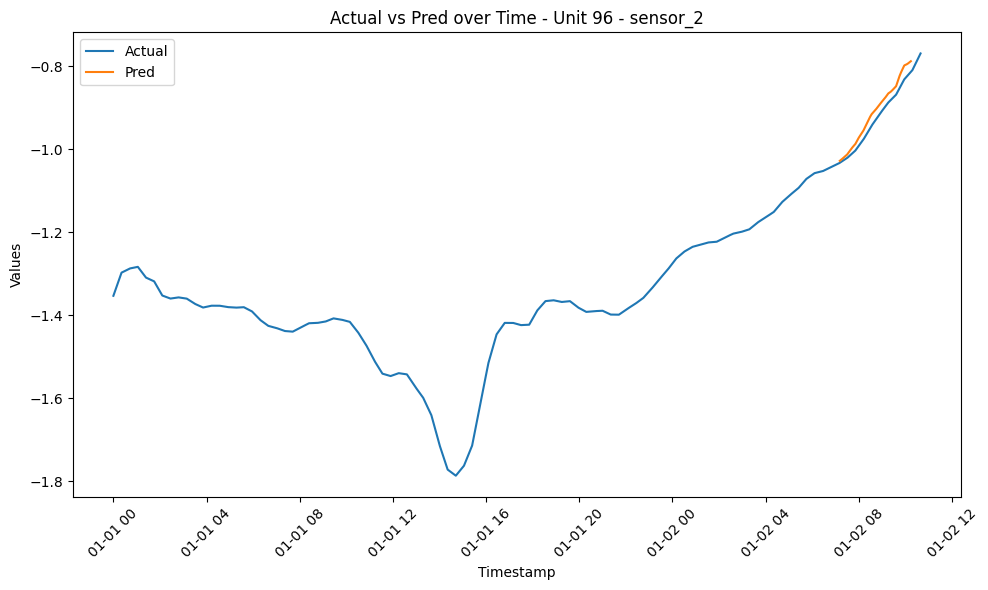

RMSE for Unit 96 - sensor_2: 0.010904820879970963


  0%|          | 0/87 [00:00<?, ?it/s]

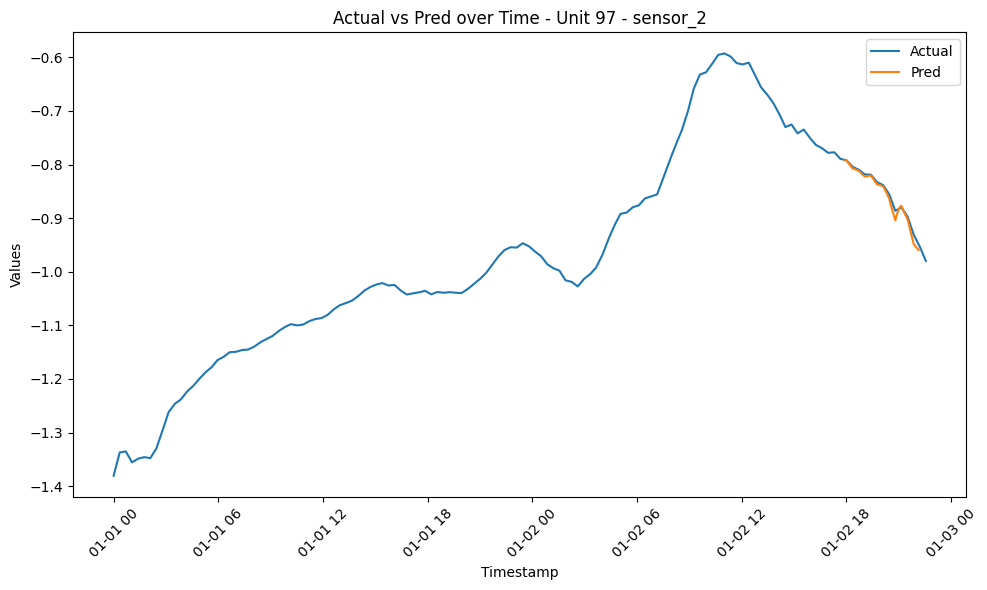

RMSE for Unit 97 - sensor_2: 0.015089007064087313


  0%|          | 0/84 [00:00<?, ?it/s]

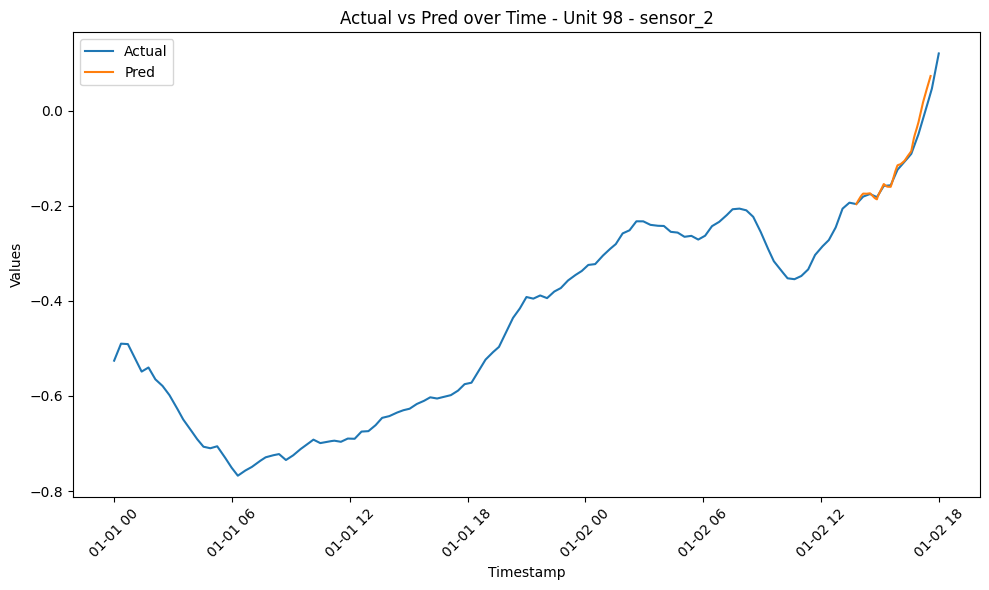

RMSE for Unit 98 - sensor_2: 0.022974371293608


  0%|          | 0/78 [00:00<?, ?it/s]

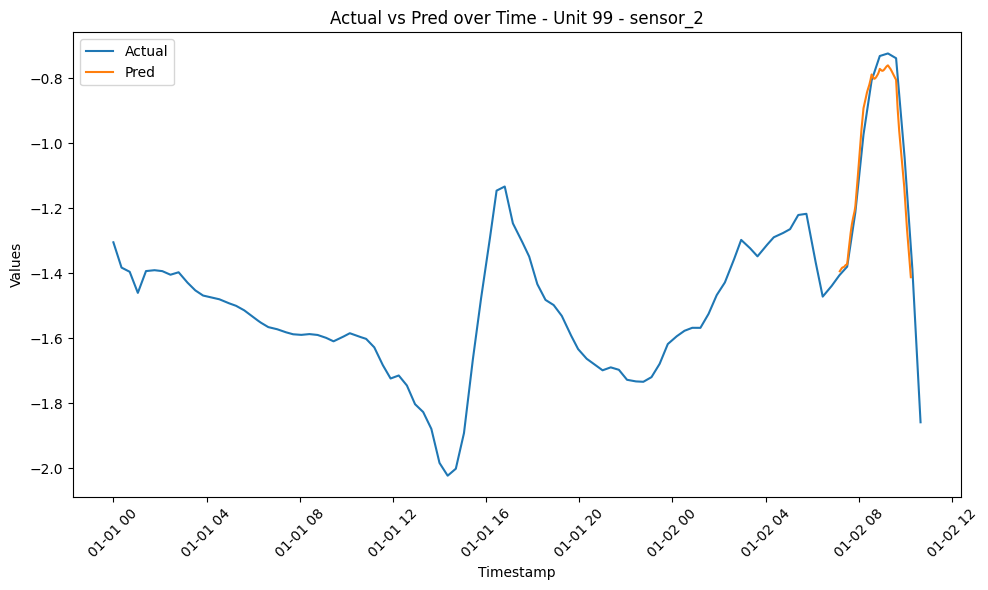

RMSE for Unit 99 - sensor_2: 0.1902626282748948


  0%|          | 0/104 [00:00<?, ?it/s]

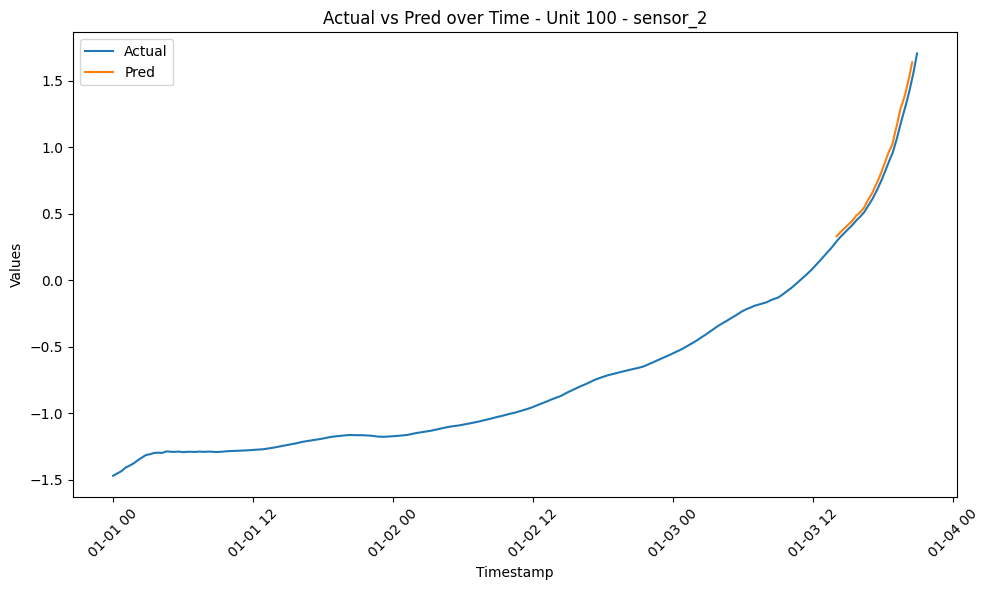

RMSE for Unit 100 - sensor_2: 0.02401336099083417


In [24]:
# Forecast each unit's sensor data
# Assuming the necessary variables (e.g., train_df, context_length, tsp, timestamp_column, target_columns) are defined

unit_list = []
rmse_list = []
split_configs = generate_split_configs(train_df, context_length)

for unit in train_df['unit_number'].unique():
    unit = int(unit)
    df_subset = train_df[train_df['unit_number'] == unit]
    df_subset = df_subset.reset_index(drop=True)
    split_config = split_configs[unit - 1]  # Access by index

    '''
    # Run data checks for debug
    print(split_config)
    print(len(df_subset))
    if df_subset is None or len(df_subset) == 0:
        print(f"No data available for unit {unit}")
    else:
        print(f"Dataset for unit {unit} is good")
    '''

    # Reset Preprocessor
    tsp = TimeSeriesPreprocessor(
      **column_specifiers,
      context_length=context_length,
      prediction_length=forecast_length,
      scaling=False,
      encode_categorical=True,
      scaler_type="standard",
    )
    
    # Generate datasets based on the split configuration
    #train_dataset, valid_dataset, test_dataset = get_datasets(tsp, dataset=df_subset, split_config=split_config, fewshot_fraction=fewshot_fraction)
    train_dataset, valid_dataset, test_dataset = get_datasets(tsp, dataset=df_subset, split_config=split_config)
    
    # Assign the zeroshot model
    zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision="main", prediction_filter_length=prediction_filter)

    # Initialize trainer with the model
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
    )

    # Evaluate the model on the test dataset
    zeroshot_trainer.evaluate(test_dataset)

    # Create a forecasting pipeline
    zs_forecast_pipeline = TimeSeriesForecastingPipeline(
        model=zeroshot_model,
        device="cpu",
        timestamp_column=timestamp_column,
        id_columns=[],  # Adjust id_columns if needed
        target_columns=target_columns,
        freq="1m"
    )

    # Retrieve test data start and end indices
    test_start_index, test_end_index = split_config['test']

    # Generate forecast
    processed_data = tsp.preprocess(df_subset[test_start_index:test_end_index])
    zs_forecast = zs_forecast_pipeline(processed_data)

    # Compare forecast with actual data and prepare for plotting
    df = compare_forecast(zs_forecast, "timestamp", "sensor_2_prediction", "sensor_2", prediction_filter)
    df.dropna(inplace=True)

    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(df_subset['timestamp'], df_subset[target_columns], label='Actual', linestyle='-')
    plt.plot(df['timestamp'], df['pred'], label='Pred', linestyle='-')

    # Add labels and legend
    #plt.axvline(x=df_subset['timestamp'].iloc[test_start_index], color='red', linestyle='--', label='Test Start')
    plt.xlabel('Timestamp')
    plt.ylabel('Values')
    plt.title('Actual vs Pred over Time - Unit ' + str(unit) + ' - ' + target_columns[0])
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Calculate RMSE for the unit
    rmse = np.sqrt(mean_squared_error(df['actual'], df['pred']))
    print(f"RMSE for Unit {unit} - {target_columns[0]}: {rmse}")
    unit_list.append(unit)
    rmse_list.append(rmse)
    

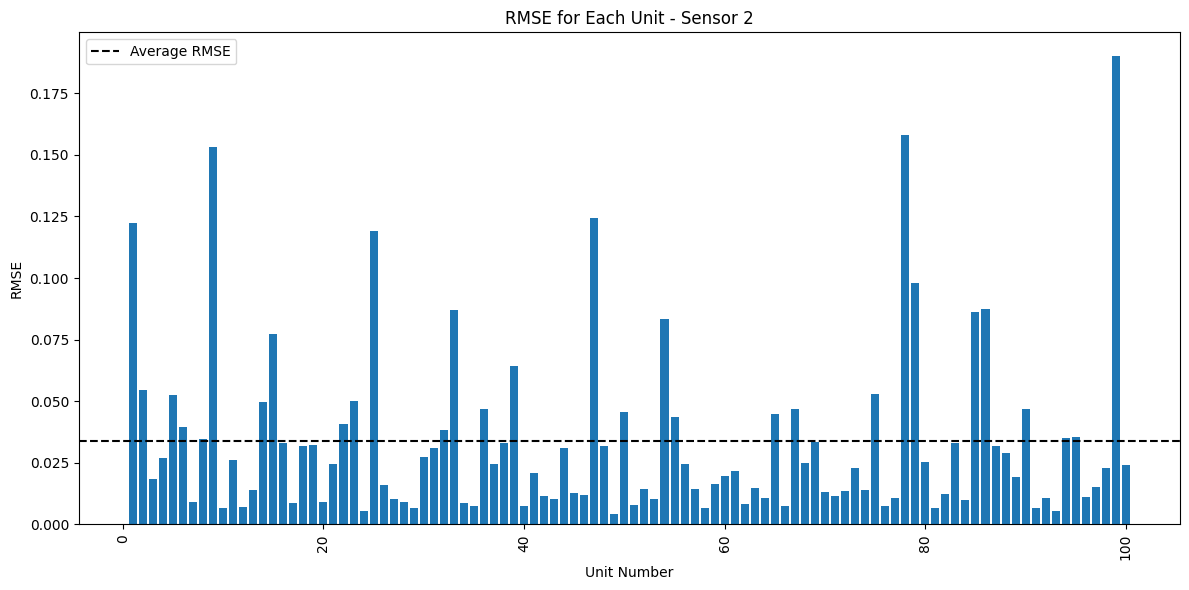

Average RMSE:  0.03369672328052685


In [25]:
plt.figure(figsize=(12, 6))
plt.bar(unit_list, rmse_list)
plt.axhline(y=np.mean(rmse_list), color='black', linestyle='--', label='Average RMSE')
plt.xlabel('Unit Number')
plt.ylabel('RMSE')
plt.title('RMSE for Each Unit - Sensor 2')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

print("Average RMSE: ", np.mean(rmse_list))